In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
import ast
# import moss
import csv
import random
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from matplotlib.ticker import PercentFormatter
from statsmodels.stats.anova import AnovaRM
from sklearn.preprocessing import StandardScaler
from matplotlib.cm import get_cmap
from plot_utils import combined_rolling_average_and_model_fit, combined_sliding_window_and_model_fit_split_col
from common_functions import remove_unit_variance

In [3]:
scaler = StandardScaler()

df = pd.read_csv('pilot_total.csv')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df_cleaned = pd.read_csv('pilot_total_errors.csv')


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_3554/45566082.py:3: DtypeWarning: Columns (254,255,256,257,258,259) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('pilot_total.csv')
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_3554/45566082.py:5: DtypeWarning: Columns (157,254,255,256,257,258,259) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv('pilot_total_errors.csv')


In [4]:
# df_cleaned['wm_untested_choice_num']

In [5]:
df['it_pos_neg'] =  np.where(df['it_sim_dis_diff_test'] <= 0, 0, 1)
df['v2_pos_neg'] =  np.where(df['v2_sim_dis_diff_test'] <= 0, 0, 1)
df_correct = df[df['resp_correct'] == 1]
#this approach here seems more correct
df_correct['wm_rt'] = df_correct['mouse.time_last'] * 1000
# df_correct['wm_rt'] = np.log(df_correct['wm_rt'])
df_correct = remove_unit_variance(df_correct,'wm_rt', 'participant')
df_correct['WM RT'] = df_correct['wm_rt']


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_3554/2543274082.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct['wm_rt'] = df_correct['mouse.time_last'] * 1000


In [6]:
df_correct['WM RT']

0        1694.9
2         894.8
3        2095.7
5         895.8
8        1261.2
          ...  
80630    1430.0
80631    2181.0
80632    2562.0
80633    2031.0
80635    2164.0
Name: WM RT, Length: 60219, dtype: float64

In [7]:
sns.set_context('notebook')

In [8]:

blue = '#90BDEC'
gray = '#BFBFBF'

# Create a palette list
palette = [blue, gray]
sns.set_palette(palette)  # Set as default palette


In [9]:
df_cleaned['Error Category Accuracy'] = df_cleaned['wm_category_num']# use these for the errors - old ( if the errors are from the correct categories)
df_cleaned['Untested Item Error Accuracy'] = df_cleaned['wm_untested_choice_num'] # new errors 

df['Accuracy'] = df['resp_correct']
# df_filtered = remove_unit_variance(df_filtered, 'resp_correct', 'participant')
# df_filtered['Accuracy'] = df_filtered['resp_correct_within']
    

In [10]:
df_cleaned['Error Category Accuracy']

0        0
1        1
2        1
3        0
4        0
        ..
17292    1
17293    0
17294    1
17295    1
17296    0
Name: Error Category Accuracy, Length: 17297, dtype: int64

In [11]:
df_correct['WM RT']

0        1694.9
2         894.8
3        2095.7
5         895.8
8        1261.2
          ...  
80630    1430.0
80631    2181.0
80632    2562.0
80633    2031.0
80635    2164.0
Name: WM RT, Length: 60219, dtype: float64

Total points: 17297, Window size: 3459, Step size: 345


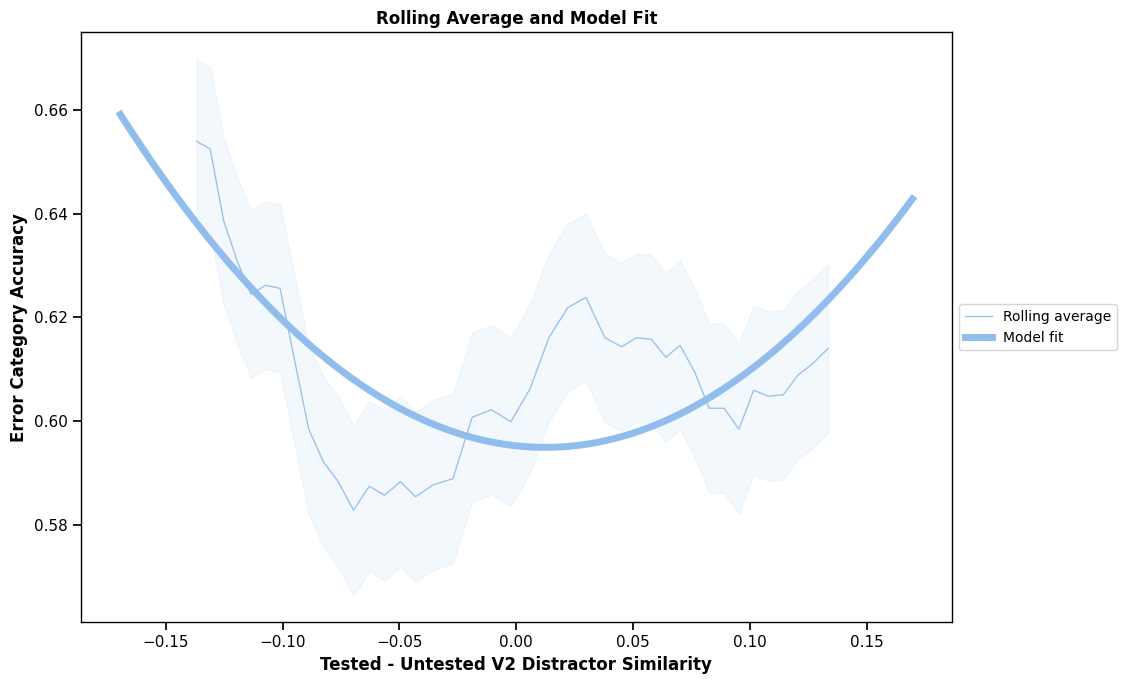

In [12]:
# Call the function
combined_plot = combined_rolling_average_and_model_fit(
    df_cleaned, 
    x_col="Tested - Untested V2 Distractor Similarity",
    y_col="Error Category Accuracy", 
    item_col=None,  # Can be None to avoid splitting
    window_percent=0.2,
    step_percent=0.02,
    palette=palette
)

# Show the plot
plt.show()

Negative side - All Data, Total points: 9120, Window size: 1824, Step size: 182
Positive side - All Data, Total points: 8177, Window size: 1635, Step size: 163


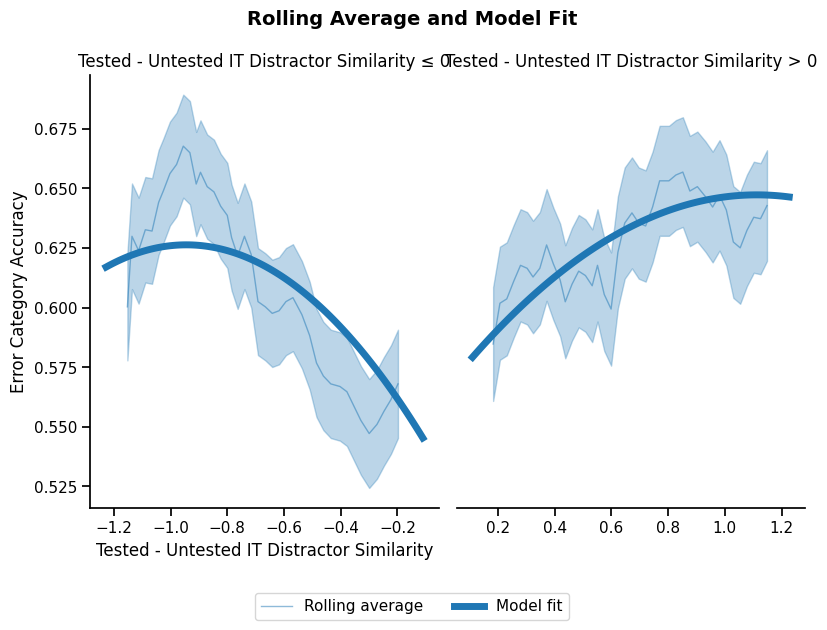

In [13]:
# Call with aspect ratio of 0.7
fig = combined_sliding_window_and_model_fit_split_col(
    df_cleaned, 
    x_col="Tested - Untested IT Distractor Similarity",
    y_col="Error Category Accuracy", 

    # item_col="Tested Item",
    split_col="IT_pos_neg",
    split_value=0,
    window_percent=0.2, 
    step_percent=0.02,
    # palette=['#90BDEC', '#BFBFBF'],
    aspect=0.7  # Set aspect ratio to 0.7
)


Total points: 80637, Window size: 16127, Step size: 1612
Total points: 60219, Window size: 12043, Step size: 1204
Total points: 17297, Window size: 3459, Step size: 345


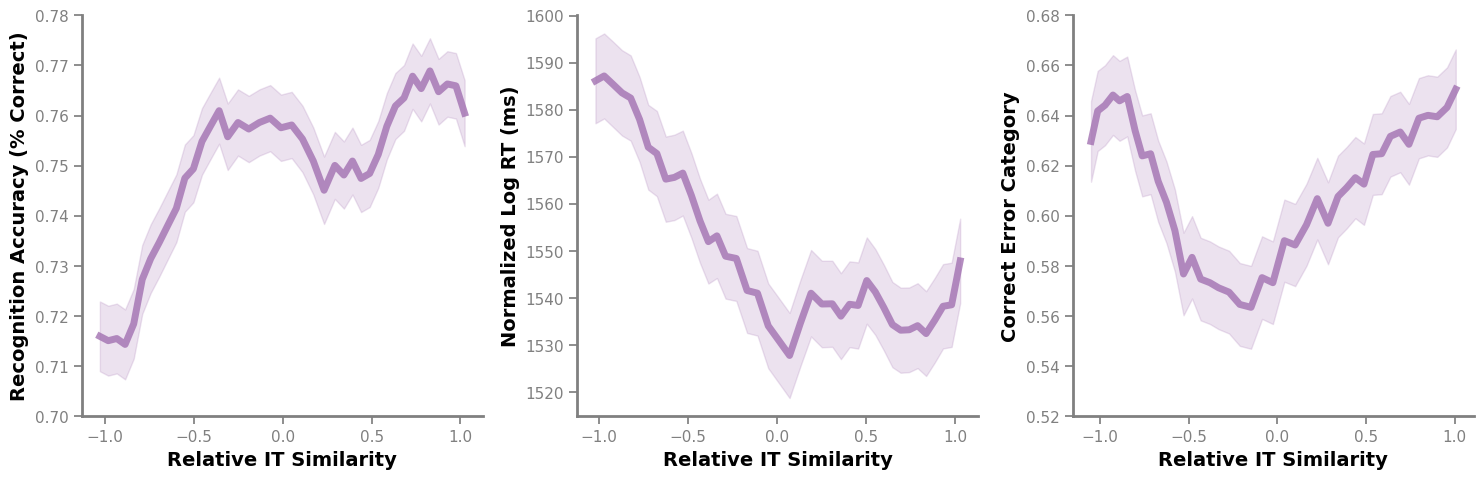

In [14]:

def combined_rolling_average_subplot(df, x_col="Tested - Untested IT Distractor Similarity", 
                                    y_col='Accuracy', item_col=None,
                                    window_percent=0.2, step_percent=0.01,
                                    palette=None, ax=None, show_title=True, show_xlabel=True):
    # Use provided axis or create new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 7))
        created_fig = True
    else:
        fig = ax.get_figure()
        created_fig = False
    
    # Set background colors
    if created_fig:
        fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Remove grid
    ax.grid(False)
    
    # Use provided palette or default
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
    # if palette is None:
    palette = [purple]
    
    # Color map for specific item types (using palette colors)
    color_map = {
        'prioritized': purple,
        'deprioritized': grey
    }
    
    # If splitting by item_col
    if item_col is not None and item_col in df.columns:
        # Get unique tested items
        tested_items = df[item_col].unique()
        
        # Plot rolling averages with labels
        for i, item in enumerate(tested_items):
            df_item = df[df[item_col] == item].sort_values(by=x_col).reset_index(drop=True)
            
            total_points = len(df_item)
            
            window_points = max(int(total_points * window_percent), 3)  # Ensure at least 3 points
            step_points = max(int(total_points * step_percent), 1)      # Ensure at least 1 point
            
            if total_points < window_points:
                print(f"Skipping {item} - insufficient data points ({total_points} < {window_points})")
                continue
                
            print(f"Item: {item}, Total points: {total_points}, Window size: {window_points}, Step size: {step_points}")
                
            x_values = []
            y_values = []
            y_errors = []
            
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_item.iloc[j:j+window_points]
                
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points)
                
                x_values.append(mean_x)
                y_values.append(mean_y)
                y_errors.append(sem_y)
            
            x_values = np.array(x_values)
            y_values = np.array(y_values)
            y_errors = np.array(y_errors)
            
            if len(x_values) == 0:
                continue
            
            # Select color based on item name or index in palette
            item_lower = str(item).lower()
            if item_lower in color_map:
                color = color_map[item_lower]
            elif 'prioritized' in item_lower:
                color = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                color = color_map['deprioritized']
            else:
                # Use palette color with modulo to ensure we don't go out of bounds
                color = palette[i % len(palette)]
            
            # Rolling average lines - now with labels and more visible
            ax.plot(x_values, y_values, color=color, linewidth=3, alpha=0.8, 
                   label=f'{item}')
            
            # Confidence bands
            ax.fill_between(x_values, 
                           y_values - 1.96 * y_errors,
                           y_values + 1.96 * y_errors,
                           color=color, alpha=0.2)
        
        title_suffix = f" by {item_col}"
    
    # If NOT splitting by item_col
    else:
        # Sort by x value
        df_sorted = df.sort_values(by=x_col).reset_index(drop=True)
        
        total_points = len(df_sorted)
        
        window_points = max(int(total_points * window_percent), 3)  # Ensure at least 3 points
        step_points = max(int(total_points * step_percent), 1)      # Ensure at least 1 point
        
        print(f"Total points: {total_points}, Window size: {window_points}, Step size: {step_points}")
            
        x_values = []
        y_values = []
        y_errors = []
        
        for j in range(0, total_points - window_points + 1, step_points):
            window = df_sorted.iloc[j:j+window_points]
            
            mean_x = window[x_col].mean()
            mean_y = window[y_col].mean()
            
            std_y = window[y_col].std()
            sem_y = std_y / np.sqrt(window_points)
            
            x_values.append(mean_x)
            y_values.append(mean_y)
            y_errors.append(sem_y)
        
        x_values = np.array(x_values)
        y_values = np.array(y_values)
        y_errors = np.array(y_errors)
        
        # Use first color from palette
        color = palette[0]
        
        # Rolling average line with label
        ax.plot(x_values, y_values, color=color, linewidth=5, alpha=0.8)
        
        # Confidence bands
        ax.fill_between(x_values, 
                       y_values - 1.96 * y_errors,
                       y_values + 1.96 * y_errors,
                       color=color, alpha=0.2)
                
        title_suffix = ""
    
    # Styling for axes and labels
    if show_xlabel:
        ax.set_xlabel(x_col, fontweight='bold', fontsize=14)
    else:
        ax.set_xlabel('')  # Remove x-axis label
    
    ax.set_ylabel(y_col, fontweight='bold', fontsize=14)
    
    # Don't create legend at subplot level when not standalone
    if created_fig:
        # Create legend and position it OUTSIDE the plot
        legend = ax.legend(frameon=True, fontsize=8, loc='center left', bbox_to_anchor=(1.0, 0.5))

    # Custom axis labels
    if x_col in ["Tested - Untested IT Distractor Similarity"]:
        ax.set_xlabel("Relative IT Similarity", fontweight='bold', fontsize=14)

    if x_col in ["Tested - Untested V2 Distractor Similarity"]:
        ax.set_xlabel("Relative V2 Similarity", fontweight='bold', fontsize=14)

    # Set y-axis limits if applicable
    if y_col.lower() in ['accuracy']:
        ax.set_ylabel("Recognition Accuracy (% Correct)", fontweight='bold', fontsize=14)

    if y_col.lower() in ['wm rt']:
        ax.set_ylabel("Normalized Log RT (ms)", fontweight='bold', fontsize=14)

    if y_col.lower() in ['error category accuracy']:
        ax.set_ylabel("Correct Error Category", fontweight='bold', fontsize=14)
    
    # Add spines with minimal styling - remove top and right borders
    ax.spines['left'].set_color('grey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='x', colors='grey')
    ax.tick_params(axis='y', colors='grey')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Only adjust layout if we created the figure
    if created_fig:
        plt.tight_layout()
        plt.subplots_adjust(right=0.8)  # Make room for the legend on the right
    
    return fig


# Example usage with different dataframes for each plot in a 3x1 grid
plot_configs = [
    {
        'df': df,  # Add dataframe to each config
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None
    },
    {
        'df': df_correct,  # Another dataframe
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None
    },
    {
        'df': df_cleaned,  # Another dataframe
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Error Category Accuracy",
        'item_col': None
    }
]

# Create the 3x1 grid
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Keep track of all handles and labels for the shared legend
all_handles = []
all_labels = []

for i, config in enumerate(plot_configs):
    combined_rolling_average_subplot(
        config['df'],  # Use the dataframe from config
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config['item_col'],
        window_percent=0.2,
        step_percent=0.02,
        palette=palette,
        ax=axes[i]
    )
    
    # Set y-axis limits for each subplot
    if i == 0: 
        axes[i].set_ylim(0.7, 0.78)
    # elif i == 1:  # RT plot
    #     axes[i].set_ylim(0.36, 0.42)
    elif i == 2:  # Error accuracy plot
        axes[i].set_ylim(0.52, 0.68)
    
    # Collect handles and labels from this subplot
    handles, labels = axes[i].get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in all_labels:  # Only add unique labels
            all_handles.append(handle)
            all_labels.append(label)

# Create one shared legend for the entire figure (only if there are legend items)
if all_handles and all_labels:
    fig.legend(all_handles, all_labels, loc='center', bbox_to_anchor=(0.5, 0.02), 
               ncol=len(all_labels), frameon=True, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the shared legend
plt.show()


In [15]:
# Use provided palette or default
grey = '#BFBFBF'
blue = '#6cbcef'
teal = '#49a791'
purple = '#a271b1'
salmon = '#e58a72'
gold = '#dbad40'
green = '#95c355'

Total points: 80637, Window size: 8063, Step size: 403


NameError: name 'FuncFormatter' is not defined

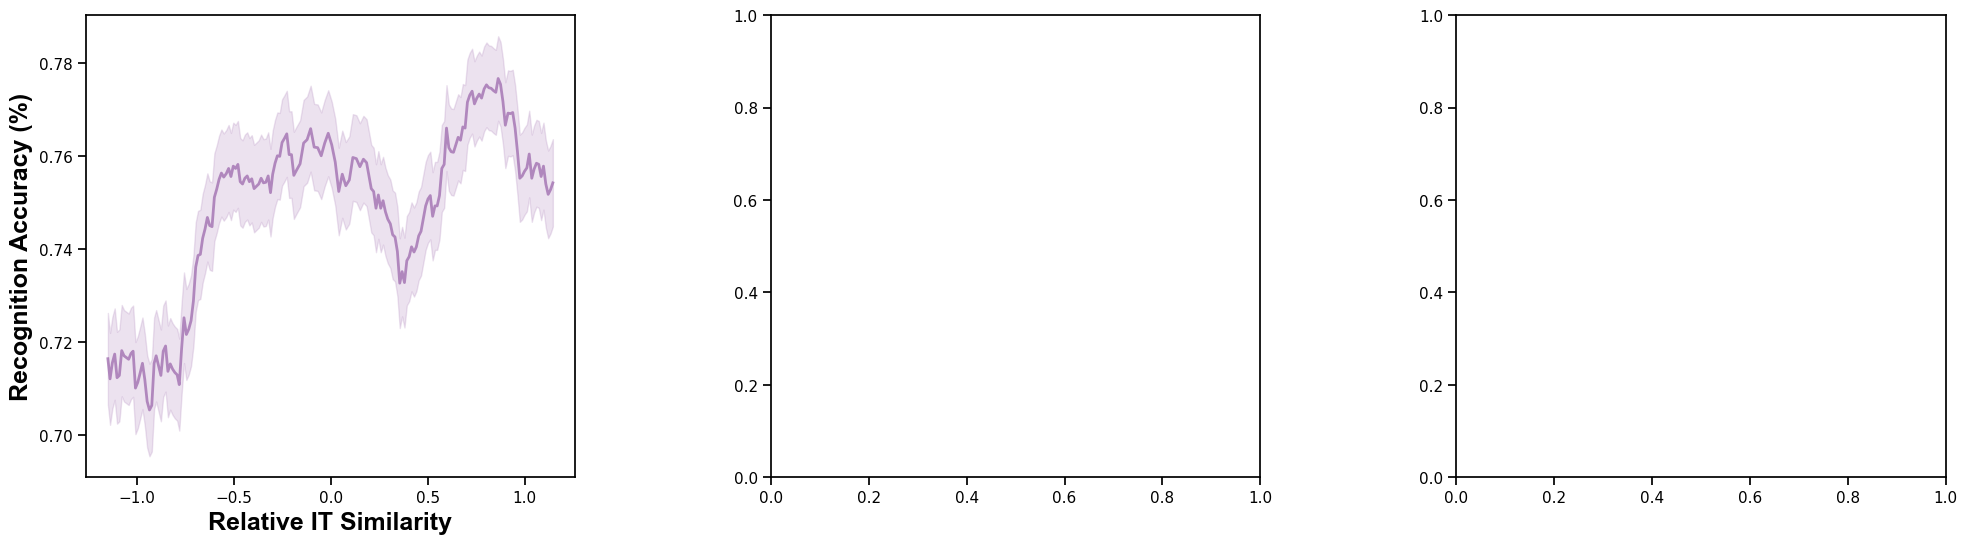

In [16]:


def combined_rolling_average_subplot(df, x_col="Tested - Untested IT Distractor Similarity", 
                                    y_col='Accuracy', item_col=None,
                                    window_percent=0.2, step_percent=0.01,
                                    palette=None, ax=None, show_title=True, show_xlabel=True,
                                    
                                    # Font and color parameters
                                    font_family='Arial', 
                                    title_font_size=16, title_font_color='black', title_font_weight='bold',
                                    label_font_size=14, label_font_color='black', label_font_weight='bold',
                                    tick_font_size=12, tick_font_color='black',  # Changed from 'grey' to 'black'
                                    legend_font_size=10, legend_font_color='black',
                                    
                                    # Axis formatting parameters
                                    y_as_percentage=False, y_percentage_step=2, 
                                    x_tick_step=None, y_tick_step=None,
                                    x_limits=None, y_limits=None,
                                    x_ticks=None,  # NEW: explicit x-tick positions
                                    x_remove_leading_zero = True,
                                    # Spacing parameters
                                    line_width=2, confidence_alpha=0.2):
    """
    Enhanced rolling average subplot with customizable fonts, colors, and formatting.
    
    Parameters:
    -----------
    df : DataFrame
        Input data
    x_col, y_col : str
        Column names for x and y axes
    item_col : str, optional
        Column name for grouping items
    window_percent, step_percent : float
        Rolling window parameters
    palette : list, optional
        Color palette for lines
    ax : matplotlib axis, optional
        Axis to plot on
    show_title, show_xlabel : bool
        Whether to show title and x-label
    
    Font and color parameters:
    font_family : str
        Font family for all text
    title_font_size, label_font_size, tick_font_size, legend_font_size : int
        Font sizes for different elements
    title_font_color, label_font_color, tick_font_color, legend_font_color : str
        Font colors for different elements
    title_font_weight, label_font_weight : str
        Font weights ('normal', 'bold', etc.)
    
    Axis formatting parameters:
    y_as_percentage : bool
        Whether to format y-axis as percentages
    y_percentage_step : float
        Step size for percentage ticks (e.g., 2 for every 2%)
    x_tick_step, y_tick_step : float, optional
        Custom tick step sizes
    x_limits, y_limits : tuple, optional
        Custom axis limits (min, max)
    x_ticks : array-like, optional
        Explicit x-tick positions (overrides x_tick_step)
    
    Spacing parameters:
    line_width : float
        Width of the rolling average lines
    confidence_alpha : float
        Alpha value for confidence bands
    """
    
    # Use provided axis or create new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 7))
        created_fig = True
    else:
        fig = ax.get_figure()
        created_fig = False
    
    # Set background colors
    if created_fig:
        fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Remove grid
    ax.grid(False)
    
    # Use provided palette or default
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
    # Auto-select color based on x_col if no palette provided
    if palette is None:
        if "IT Distractor Similarity" in x_col:
            palette = [purple]
            color_map = {
                'prioritized': purple,
                'deprioritized': grey
            }
        elif "V2 Distractor Similarity" in x_col:
            palette = [teal]
            color_map = {
                        'prioritized': teal,
                        'deprioritized': grey
                    }
        else:
            palette = [purple]  # default
    
    # If splitting by item_col
    if item_col is not None and item_col in df.columns:
        # Get unique tested items
        tested_items = df[item_col].unique()
        
        # Plot rolling averages with labels
        for i, item in enumerate(tested_items):
            df_item = df[df[item_col] == item].sort_values(by=x_col).reset_index(drop=True)
            
            total_points = len(df_item)
            
            window_points = max(int(total_points * window_percent), 3)  # Ensure at least 3 points
            step_points = max(int(total_points * step_percent), 1)      # Ensure at least 1 point
            
            if total_points < window_points:
                print(f"Skipping {item} - insufficient data points ({total_points} < {window_points})")
                continue
                
            print(f"Item: {item}, Total points: {total_points}, Window size: {window_points}, Step size: {step_points}")
                
            x_values = []
            y_values = []
            y_errors = []
            
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_item.iloc[j:j+window_points]
                
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points)
                
                x_values.append(mean_x)
                y_values.append(mean_y)
                y_errors.append(sem_y)
            
            x_values = np.array(x_values)
            y_values = np.array(y_values)
            y_errors = np.array(y_errors)
            
            if len(x_values) == 0:
                continue
            
            # Select color based on item name or index in palette
            item_lower = str(item).lower()
            if item_lower in color_map:
                color = color_map[item_lower]
            elif 'prioritized' in item_lower:
                color = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                color = color_map['deprioritized']
            else:
                # Use palette color with modulo to ensure we don't go out of bounds
                color = palette[i % len(palette)]
            
            # Rolling average lines - now with customizable line width
            ax.plot(x_values, y_values, color=color, linewidth=line_width, alpha=0.8, 
                   label=f'{item}')
            
            # Confidence bands with customizable alpha
            ax.fill_between(x_values, 
                           y_values - 1.96 * y_errors,
                           y_values + 1.96 * y_errors,
                           color=color, alpha=confidence_alpha)
        
        title_suffix = f" by {item_col}"
    
    # If NOT splitting by item_col
    else:
        # Sort by x value
        df_sorted = df.sort_values(by=x_col).reset_index(drop=True)
        
        total_points = len(df_sorted)
        
        window_points = max(int(total_points * window_percent), 3)  # Ensure at least 3 points
        step_points = max(int(total_points * step_percent), 1)      # Ensure at least 1 point
        
        print(f"Total points: {total_points}, Window size: {window_points}, Step size: {step_points}")
            
        x_values = []
        y_values = []
        y_errors = []
        
        for j in range(0, total_points - window_points + 1, step_points):
            window = df_sorted.iloc[j:j+window_points]
            
            mean_x = window[x_col].mean()
            mean_y = window[y_col].mean()
            
            std_y = window[y_col].std()
            sem_y = std_y / np.sqrt(window_points)
            
            x_values.append(mean_x)
            y_values.append(mean_y)
            y_errors.append(sem_y)
        
        x_values = np.array(x_values)
        y_values = np.array(y_values)
        y_errors = np.array(y_errors)
        
        # Use first color from palette
        color = palette[0]
        
        # Rolling average line with customizable line width
        ax.plot(x_values, y_values, color=color, linewidth=line_width, alpha=0.8)
        
        # Confidence bands with customizable alpha
        ax.fill_between(x_values, 
                       y_values - 1.96 * y_errors,
                       y_values + 1.96 * y_errors,
                       color=color, alpha=confidence_alpha)
                
        title_suffix = ""
    
    # Styling for axes and labels with customizable fonts
    if show_xlabel:
        ax.set_xlabel(x_col, fontweight=label_font_weight, fontsize=label_font_size, 
                     color=label_font_color, fontfamily=font_family)
    else:
        ax.set_xlabel('')  # Remove x-axis label
    
    ax.set_ylabel(y_col, fontweight=label_font_weight, fontsize=label_font_size, 
                 color=label_font_color, fontfamily=font_family)
    
    # Custom axis labels with font styling
    if x_col in ["Tested - Untested IT Distractor Similarity"]:
        ax.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                     fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    if x_col in ["Tested - Untested V2 Distractor Similarity"]:
        ax.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                     fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    # Set y-axis labels and formatting
    if y_col.lower() in ['accuracy']:
        if y_as_percentage:
            ax.set_ylabel("Recognition Accuracy (%)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
            # Format y-axis as percentages and set custom ticks
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
            if y_tick_step is None:
                y_tick_step = y_percentage_step / 100.0  # Convert percentage to decimal
        else:
            ax.set_ylabel("Recognition Accuracy (% Correct)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    if y_col.lower() in ['wm rt']:
        ax.set_ylabel("Normalized Log RT (ms)", fontweight=label_font_weight, 
                     fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    if y_col.lower() in ['error category accuracy']:
        if y_as_percentage:
            ax.set_ylabel("Correct Error Category (%)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
            # Format y-axis as percentages and set custom ticks
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
            if y_tick_step is None:
                y_tick_step = y_percentage_step / 100.0  # Convert percentage to decimal
        else:
            ax.set_ylabel("Correct Error Category", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
    
    # Set custom x-axis ticks (NEW FEATURE)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    elif x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    
    # Set custom y-axis ticks
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))

    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Set custom axis limits
    if x_limits is not None:
        ax.set_xlim(x_limits)


    
    # Set custom axis limits
    if x_limits is not None:
        ax.set_xlim(x_limits)
    
    if y_limits is not None:
        ax.set_ylim(y_limits)
    
    # Style tick labels with custom fonts
    ax.tick_params(axis='x', colors=tick_font_color, labelsize=tick_font_size)
    ax.tick_params(axis='y', colors=tick_font_color, labelsize=tick_font_size)
    
    # Set font family for tick labels
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    # Don't create legend at subplot level when not standalone
    if created_fig:
        # Create legend with custom font styling
        legend = ax.legend(frameon=True, fontsize=legend_font_size, loc='center left', 
                          bbox_to_anchor=(1.0, 0.5))
        # Style legend text
        for text in legend.get_texts():
            text.set_fontfamily(font_family)
            text.set_color(legend_font_color)
    
    # Add spines with minimal styling - remove top and right borders
    ax.spines['left'].set_color('grey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Only adjust layout if we created the figure
    if created_fig:
        plt.tight_layout()
        plt.subplots_adjust(right=0.8)  # Make room for the legend on the right
    
    return fig


# Enhanced example usage with your specified x-axis settings
plot_configs = [
    {
        'df': df,  # Add dataframe to each config
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,  # Format as percentages
        'y_percentage_step': 2,   # Every 2%
        'y_limits': (0.7, 0.8), # Custom y-axis limits
        'x_limits': (-1.4, 1.4), # NEW: Your specified x-limits
        'x_tick_step': 0.4,      # NEW: Ticks every 0.2
        'font_family': 'Arial',
        'label_font_size': 18,    # Increased from 14
        'tick_font_size': 16      # Increased from 12
    },
    {
        'df': df_correct,  # Another dataframe
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None,
        'y_limits': (1.5, 1.65),
        'y_tick_step': 0.02,  # Custom y-axis step
        'x_limits': (-1.4, 1.4), # NEW: Your specified x-limits
        'x_tick_step': 0.4,      # NEW: Ticks every 0.2
        'font_family': 'Arial',
        'label_font_size': 18,    # Increased from 14
        'tick_font_size': 16      # Increased from 12
    },
    {
        'df': df_cleaned,  # Another dataframe
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Error Category Accuracy",
        'item_col': None,
        'y_as_percentage': True,  # Added percentage formatting
        'y_percentage_step': 4,   # Every 4% for this plot
        'y_limits': (0.52, 0.69),
        'y_tick_step': 0.04,  # Custom y-axis step
        'x_limits': (-1.4, 1.4), # NEW: Your specified x-limits
        'x_tick_step': 0.4,      # NEW: Ticks every 0.2
        'font_family': 'Arial',
        'label_font_size': 18,    # Increased from 14
        'tick_font_size': 16      # Increased from 12
    }
]

# Alternative: Using explicit x_ticks instead of x_tick_step
x_tick_positions = np.arange(-1.4, 1.6, 0.2)  # Creates [-1.4, -1.2, -1.0, ..., 1.2, 1.4]

plot_configs_alternative = [
    {
        'df': df,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'y_limits': (0.7, 0.8),
        'x_limits': (-1.4, 1.4),
        'x_tick_step': 0.4,      # NEW: Ticks every 0.2
        'font_family': 'Arial',
        'label_font_size': 18,
        'tick_font_size': 16
    },
    # ... (similar for other plots)
]

# Create the 3x1 grid with increased spacing
fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # Increased figure width for more spacing
fig.subplots_adjust(wspace=0.4)  # Increase horizontal spacing between subplots

# Keep track of all handles and labels for the shared legend
all_handles = []
all_labels = []

for i, config in enumerate(plot_configs):
    combined_rolling_average_subplot(
        config['df'],  # Use the dataframe from config
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config['item_col'],
        window_percent=0.1,
        step_percent=0.005,
        ax=axes[i],
        
        # Pass the custom formatting options
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        y_limits=config.get('y_limits'),
        y_tick_step=config.get('y_tick_step'),
        x_limits=config.get('x_limits'),      # NEW: X-axis limits
        x_tick_step=config.get('x_tick_step'), # NEW: X-axis tick step
        x_ticks=config.get('x_ticks'),        # NEW: Explicit x-ticks

        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 18),
        tick_font_size=config.get('tick_font_size', 16)
    )
    
    # Collect handles and labels from this subplot
    handles, labels = axes[i].get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in all_labels:  # Only add unique labels
            all_handles.append(handle)
            all_labels.append(label)

# Create one shared legend for the entire figure (only if there are legend items)
if all_handles and all_labels:
    fig.legend(all_handles, all_labels, loc='center', bbox_to_anchor=(0.5, 0.02), 
               ncol=len(all_labels), frameon=True, fontsize=14)  # Increased legend font size

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, wspace=0.4)  # Make room for the shared legend and increase spacing
plt.show()

Total points: 80637, Window size: 8063, Step size: 1612


NameError: name 'FuncFormatter' is not defined

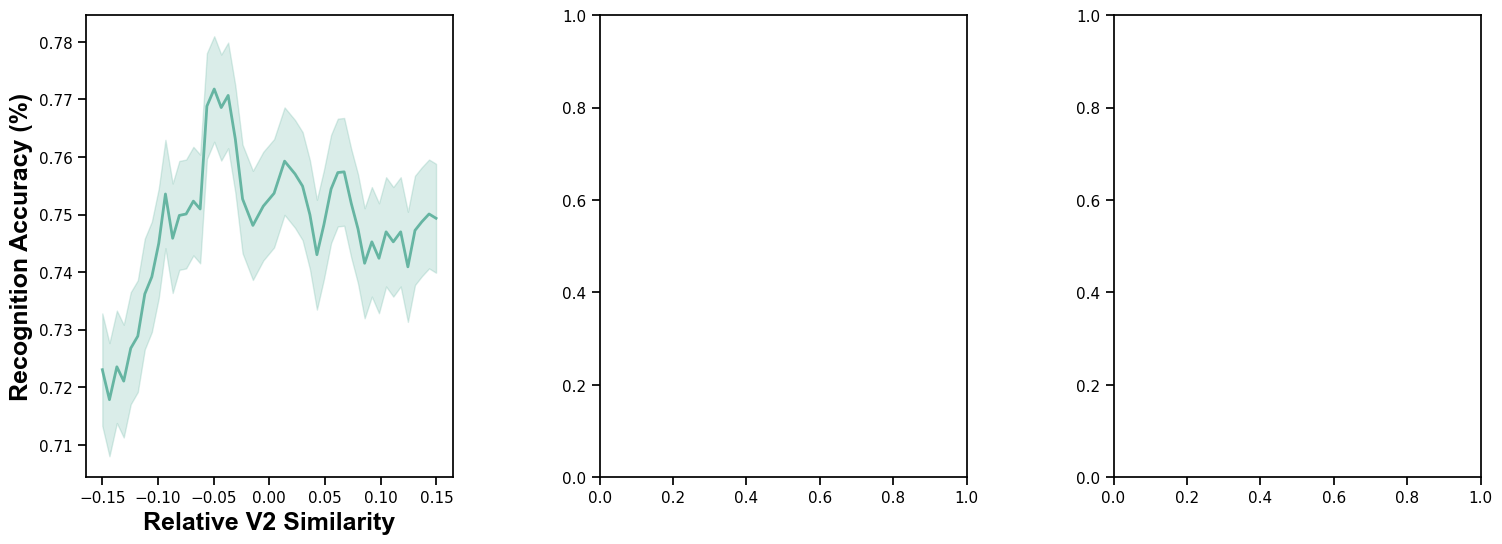

In [17]:
plot_configs = [
    {
        'df': df,  # Add dataframe to each config
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,  # Format as percentages
        'y_percentage_step': 2,   # Every 2%
        'y_limits': (0.7, 0.8), # Custom y-axis limits
        'x_limits': (-0.2, 0.2), # NEW: X-axis limits
        'x_tick_step': 0.06,     # NEW: Ticks every 0.04
        'font_family': 'Arial',
        'label_font_size': 18,
        'tick_font_size': 16
    },
    {
        'df': df_correct,  # Another dataframe
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None,
        'y_limits': (1.5, 1.65),
        'y_tick_step': 0.02,  # Custom y-axis step
        'x_limits': (-0.2, 0.2), # NEW: X-axis limits
        'x_tick_step': 0.06,     # NEW: Ticks every 0.04
        'font_family': 'Arial',
        'label_font_size': 18,
        'tick_font_size': 16
    },
    {
        'df': df_cleaned,  # Another dataframe
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "Error Category Accuracy",
        'item_col': None,
        'y_limits': (0.52, 0.69),
        'y_tick_step': 0.04,  # Custom y-axis step
        'y_as_percentage': True,  # Added percentage formatting
        'y_percentage_step': 4,   # Every 4% for this plot
        'x_limits': (-0.2, 0.2), # NEW: X-axis limits
        'x_tick_step': 0.06,     # NEW: Ticks every 0.04
        'font_family': 'Arial',
        'label_font_size': 18,
        'tick_font_size': 16
    }
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Increased figure width for more spacing
fig.subplots_adjust(wspace=0.4)  # Increase horizontal spacing between subplots

# Keep track of all handles and labels for the shared legend
all_handles = []
all_labels = []

for i, config in enumerate(plot_configs):
    combined_rolling_average_subplot(
        config['df'],  # Use the dataframe from config
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config['item_col'],
        window_percent=0.1,
        step_percent=0.02,
        ax=axes[i],
        
        # Pass the custom formatting options
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        y_limits=config.get('y_limits'),
        y_tick_step=config.get('y_tick_step'),
        x_limits=config.get('x_limits'),      # NEW: X-axis limits
        x_tick_step=config.get('x_tick_step'), # NEW: X-axis tick step
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 14),
        tick_font_size=config.get('tick_font_size', 12)
    )
    
    # Collect handles and labels from this subplot
    handles, labels = axes[i].get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in all_labels:  # Only add unique labels
            all_handles.append(handle)
            all_labels.append(label)

# Create one shared legend for the entire figure (only if there are legend items)
if all_handles and all_labels:
    fig.legend(all_handles, all_labels, loc='center', bbox_to_anchor=(0.5, 0.02), 
               ncol=len(all_labels), frameon=True, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, wspace=0.4)  # Make room for the shared legend and increase spacing
plt.show()

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator

def remove_leading_zero_formatter(x, pos):
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def create_continuous_rolling_plot(df, df_correct, df_cleaned, x_col, y_col, item_col=None, 
                                 window_percent=0.1, step_percent=0.02,
                                 ax=None, 
                                 y_limits=None, x_limits=None,
                                 x_tick_step=None, y_tick_step=None, x_ticks=None,
                                 y_as_percentage=False, y_percentage_step=2,
                                 font_family='Arial',
                                 title_font_size=18, title_font_color='black', title_font_weight='bold',
                                 label_font_size=16, label_font_color='black', label_font_weight='bold',
                                 tick_font_size=14, tick_font_color='black',
                                 line_width=3, confidence_alpha=0.2,
                                 show_title=True):
    
    # Select the appropriate dataframe based on the y_col
    if y_col.lower() in ['wm rt', 'rt', 'reaction_time', 'response_time']:
        df = df_correct.copy()
        print(f"Continuous plot using df_correct for {y_col}")
    elif y_col.lower() in ['error category accuracy', 'error_category_accuracy', 'within_category_errors', 'untested item error accuracy']:
        df = df_cleaned.copy()
        print(f"Continuous plot using df_cleaned for {y_col}")
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct', 'choice_accuracy']:
        df = df.copy()
        print(f"Continuous plot using df for {y_col}")
    else:
        # Default to main df if unclear
        df = df.copy()
        print(f"Continuous plot using default df for {y_col}")
    
    if "IT Distractor Similarity" in x_col:
        palette = ['#49a791']
    elif "V2 Distractor Similarity" in x_col:
        palette = ['#95c355']
    else:
        palette = ['#49a791']
    
    fig = combined_rolling_average_subplot(
        df=df, 
        x_col=x_col, 
        y_col=y_col, 
        item_col=item_col,
        window_percent=window_percent, 
        step_percent=step_percent,
        palette=palette,
        ax=ax, 
        show_title=False,
        show_xlabel=True,
        font_family=font_family, 
        title_font_size=title_font_size, 
        title_font_color=title_font_color, 
        title_font_weight=title_font_weight,
        label_font_size=label_font_size, 
        label_font_color=label_font_color, 
        label_font_weight=label_font_weight,
        tick_font_size=tick_font_size-2,
        tick_font_color=tick_font_color,
        y_as_percentage=y_as_percentage, 
        y_percentage_step=y_percentage_step, 
        x_tick_step=x_tick_step, 
        y_tick_step=y_tick_step,
        x_limits=x_limits, 
        y_limits=y_limits,
        x_ticks=x_ticks,
        line_width=line_width, 
        confidence_alpha=confidence_alpha
    )
    
    ax.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=3)
    
    if show_title:
        ax.set_title("Continuous", fontsize=title_font_size-2, 
                    color=title_font_color, fontweight=title_font_weight, 
                    fontfamily=font_family, pad=15)
    
    ax.set_xlabel('')
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.spines['bottom'].set_visible(False)
    
    return ax


def create_single_side_plot_with_full_fit(df, df_correct, df_cleaned, x_col, y_col, item_col=None, 
                                         split_col='v2_pos_neg', split_value=0, side='left',
                                         window_percent=0.1, step_percent=0.01,
                                         ax=None, palette=None,
                                         y_limits=None, x_limits=None,
                                         x_tick_step=None, y_tick_step=None,
                                         model_order=2, trim_percentile=0,
                                         y_as_percentage=False, y_percentage_step=2,
                                         font_family='Arial',
                                         title_font_size=18, title_font_color='black', title_font_weight='bold',
                                         label_font_size=16, label_font_color='black', label_font_weight='bold',
                                         tick_font_size=14, tick_font_color='black',
                                         rolling_line_width=1, model_line_width=5,
                                         confidence_alpha=0.2, rolling_alpha=0.9,
                                         show_title=True, show_ylabel=True, show_xlabel=True):
    
    # Select the appropriate dataframe based on the y_col
    if y_col.lower() in ['wm rt', 'rt', 'reaction_time', 'response_time']:
        df = df_correct.copy()
        print(f"Using df_correct for {y_col}")
    elif y_col.lower() in ['error category accuracy', 'error_category_accuracy', 'within_category_errors', 'untested item error accuracy']:
        df = df_cleaned.copy()
        print(f"Using df_cleaned for {y_col}")
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct', 'choice_accuracy']:
        df = df.copy()
        print(f"Using df for {y_col}")
    else:
        # Default to main df if unclear
        df = df.copy()
        print(f"Using default df for {y_col}")
    
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
    if palette is None:
        if "IT Distractor Similarity" in x_col:
            default_colors = [teal, grey]
        elif "V2 Distractor Similarity" in x_col:
            default_colors = [green, grey]
        else:
            default_colors = [teal, grey]
    else:
        default_colors = palette
    
    color_map = {
        'prioritized': default_colors[0],    
        'deprioritized': default_colors[1] if len(default_colors) > 1 else grey,  
    }
    
    # Define the side data for display limits
    if side == 'left':
        df_side = df[df[x_col] <= split_value].copy()
        title_text = f"{x_col} ≤ {split_value}"
    else:
        df_side = df[df[x_col] > split_value].copy()
        title_text = f"{x_col} > {split_value}"
    
    ax.set_facecolor('white')
    
    item_color_dict = {}
    if item_col is not None and item_col in df.columns:
        all_items = df[item_col].unique()
        for i, item in enumerate(all_items):
            item_lower = str(item).lower()
            if item_lower in color_map:
                item_color_dict[item] = color_map[item_lower]
            elif 'prioritized' in item_lower:
                item_color_dict[item] = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                item_color_dict[item] = color_map['deprioritized']
            else:
                item_color_dict[item] = default_colors[i % len(default_colors)]
    
    if item_col is not None and item_col in df.columns:
        items = df[item_col].unique()
        
        # FIRST: Create rolling averages for the FULL dataset for each item
        full_rolling_data = {}
        for i, item in enumerate(items):
            df_item_full = df[df[item_col] == item].copy()
            df_item_full = df_item_full.sort_values(by=x_col).reset_index(drop=True)
            total_points_full = len(df_item_full)
            
            window_points = max(int(total_points_full * window_percent), 3)
            step_points = max(int(total_points_full * step_percent), 1)
            color = item_color_dict.get(item, default_colors[i % len(default_colors)])
            
            if total_points_full >= window_points:
                print(f"Full data - {item}, Total points: {total_points_full}, "
                      f"Window size: {window_points}, Step size: {step_points}")
                
                x_vals, y_vals, y_errs = [], [], []
                for j in range(0, total_points_full - window_points + 1, step_points):
                    window = df_item_full.iloc[j:j+window_points]
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    std_y = window[y_col].std()
                    sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                    x_vals.append(mean_x)
                    y_vals.append(mean_y)
                    y_errs.append(sem_y)
                
                full_rolling_data[item] = {
                    'x_vals': np.array(x_vals),
                    'y_vals': np.array(y_vals),
                    'y_errs': np.array(y_errs),
                    'color': color
                }
        
        # SECOND: Plot rolling averages (only the portion for this side)
        for item in items:
            if item in full_rolling_data:
                data = full_rolling_data[item]
                x_vals, y_vals, y_errs = data['x_vals'], data['y_vals'], data['y_errs']
                color = data['color']
                
                # Filter to only show the side we want
                if side == 'left':
                    mask = x_vals <= split_value
                else:
                    mask = x_vals > split_value
                
                if np.any(mask):
                    x_side = x_vals[mask]
                    y_side = y_vals[mask]
                    y_err_side = y_errs[mask]
                    
                    ax.plot(x_side, y_side, color=color, linewidth=rolling_line_width, 
                           alpha=rolling_alpha, label=f'{item} (rolling)')
                    ax.fill_between(x_side, 
                                   y_side - 1.96 * y_err_side,
                                   y_side + 1.96 * y_err_side,
                                   color=color, alpha=confidence_alpha)
        
        # THIRD: Create model fits for the FULL dataset for each item
        for i, item in enumerate(items):
            df_item_full = df[df[item_col] == item].copy()
            
            if trim_percentile > 0:
                lower_p = np.percentile(df_item_full[x_col], trim_percentile)
                upper_p = np.percentile(df_item_full[x_col], 100 - trim_percentile)
                df_item_trimmed = df_item_full[(df_item_full[x_col] >= lower_p) & (df_item_full[x_col] <= upper_p)]
            else:
                df_item_trimmed = df_item_full
                
            total_points = len(df_item_trimmed)
            color = item_color_dict.get(item, default_colors[i % len(default_colors)])
            
            if total_points >= 5:
                total_points_full = len(df_item_full)
                window_points_full = max(int(total_points_full * window_percent), 3)
                
                # Use full dataset for rolling constraints
                df_item_sorted = df_item_full.sort_values(by=x_col)
                rolling_min_x = df_item_sorted.iloc[window_points_full//2][x_col]
                rolling_max_x = df_item_sorted.iloc[-(window_points_full//2 + 1)][x_col]
                
                # Model fit range based on full data constraints
                model_min_x = max(df_item_trimmed[x_col].min(), rolling_min_x)
                model_max_x = min(df_item_trimmed[x_col].max(), rolling_max_x)
                
                points_in_model = len(df_item_trimmed[
                    (df_item_trimmed[x_col] >= model_min_x) & 
                    (df_item_trimmed[x_col] <= model_max_x)
                ])
                
                print(f"  📊 Full data - {item} Model Fit:")
                print(f"     Total points: {len(df_item_full)}")
                print(f"     Points used in model fit: {points_in_model}")
                
                if model_max_x > model_min_x:
                    # Fit model to full data within constraints
                    model_data = df_item_trimmed[
                        (df_item_trimmed[x_col] >= model_min_x) & 
                        (df_item_trimmed[x_col] <= model_max_x)
                    ]
                    
                    if len(model_data) >= 5:
                        model = np.poly1d(np.polyfit(model_data[x_col], model_data[y_col], model_order))
                        
                        # Create x range for the full model, but only plot the side we want
                        full_x_range = np.linspace(model_min_x, model_max_x, 1000)
                        
                        if side == 'left':
                            side_mask = full_x_range <= split_value
                        else:
                            side_mask = full_x_range > split_value
                        
                        if np.any(side_mask):
                            side_x_range = full_x_range[side_mask]
                            if len(side_x_range) > 0:
                                ax.plot(side_x_range, model(side_x_range), color=color, linestyle='-', 
                                        linewidth=model_line_width, label=f'{item} (model)')
    else:
        # Handle case without item_col - fit to full data
        df_full = df.copy().sort_values(by=x_col).reset_index(drop=True)
        total_points_full = len(df_full)
        
        window_points = max(int(total_points_full * window_percent), 3)
        step_points = max(int(total_points_full * step_percent), 1)
        color = default_colors[0]
        
        # Rolling average for full data
        if total_points_full >= window_points:
            print(f"Full data - All Data, Total points: {total_points_full}, "
                  f"Window size: {window_points}, Step size: {step_points}")
            
            x_vals, y_vals, y_errs = [], [], []
            for j in range(0, total_points_full - window_points + 1, step_points):
                window = df_full.iloc[j:j+window_points]
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                x_vals.append(mean_x)
                y_vals.append(mean_y)
                y_errs.append(sem_y)
            
            x_vals = np.array(x_vals)
            y_vals = np.array(y_vals)
            y_errs = np.array(y_errs)
            
            # Filter to side
            if side == 'left':
                mask = x_vals <= split_value
            else:
                mask = x_vals > split_value
            
            if np.any(mask):
                x_side = x_vals[mask]
                y_side = y_vals[mask]
                y_err_side = y_errs[mask]
                
                ax.plot(x_side, y_side, color=color, linewidth=rolling_line_width, 
                       alpha=rolling_alpha, label='Rolling average')
                ax.fill_between(x_side, 
                               y_side - 1.96 * y_err_side,
                               y_side + 1.96 * y_err_side,
                               color=color, alpha=confidence_alpha)
        
        # Model fit for full data
        if trim_percentile > 0:
            lower_p = np.percentile(df_full[x_col], trim_percentile)
            upper_p = np.percentile(df_full[x_col], 100 - trim_percentile)
            df_trimmed = df_full[(df_full[x_col] >= lower_p) & (df_full[x_col] <= upper_p)]
        else:
            df_trimmed = df_full
            
        total_points_trimmed = len(df_trimmed)
        
        if total_points_trimmed >= 5:
            window_points_full = max(int(total_points_full * window_percent), 3)
            
            df_sorted = df_full.sort_values(by=x_col)
            rolling_min_x = df_sorted.iloc[window_points_full//2][x_col]
            rolling_max_x = df_sorted.iloc[-(window_points_full//2 + 1)][x_col]
            
            model_min_x = max(df_trimmed[x_col].min(), rolling_min_x)
            model_max_x = min(df_trimmed[x_col].max(), rolling_max_x)
            
            points_in_model = len(df_trimmed[
                (df_trimmed[x_col] >= model_min_x) & 
                (df_trimmed[x_col] <= model_max_x)
            ])
            
            print(f"  📊 Full data - All Data Model Fit:")
            print(f"     Total points: {len(df_full)}")
            print(f"     Points used in model fit: {points_in_model}")
            
            if model_max_x > model_min_x:
                model_data = df_trimmed[
                    (df_trimmed[x_col] >= model_min_x) & 
                    (df_trimmed[x_col] <= model_max_x)
                ]
                
                if len(model_data) >= 5:
                    model = np.poly1d(np.polyfit(model_data[x_col], model_data[y_col], model_order))
                    
                    full_x_range = np.linspace(model_min_x, model_max_x, 1000)
                    
                    if side == 'left':
                        side_mask = full_x_range <= split_value
                    else:
                        side_mask = full_x_range > split_value
                    
                    if np.any(side_mask):
                        side_x_range = full_x_range[side_mask]
                        if len(side_x_range) > 0:
                            ax.plot(side_x_range, model(side_x_range), color=color, linestyle='-', 
                                    linewidth=model_line_width, label='Model fit')
    
    # Rest of the formatting code with updated y-axis labeling...
    if show_title:
        if side == 'left':
            ax.set_title("Negative", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
        else:
            ax.set_title("Positive", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
    
    if show_xlabel:
        if x_col in ["Tested - Untested IT Distractor Similarity"]:
            ax.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif x_col in ["Tested - Untested V2 Distractor Similarity"]:
            ax.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_xlabel(x_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    else:
        ax.set_xlabel('')
    
    if show_ylabel:
        if y_col.lower() in ['accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['wm rt']:
            ax.set_ylabel("Response Time (msec)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['error category accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Within Category Errors (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Within Category Errors", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['untested item error accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Untested Item Error Accuracy (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Untested Item Error Accuracy", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_ylabel(y_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    if x_limits is not None:
        if side == 'left':
            ax.set_xlim(x_limits[0], split_value)
        else:
            ax.set_xlim(split_value, x_limits[1])
    if y_limits is not None:
        ax.set_ylim(y_limits)
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct']:
        ax.set_ylim(0.6, 0.8)
    
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    spine_color = '#B8B8B8'
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['left'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.grid(False)
    
    return ax

def create_three_panel_visualization(df, df_correct, df_cleaned, plot_configs, middle_width=0.35, middle_height_shift=0.0, middle_size_scale=0.7, adjustable_gap=0.01):
    
    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=(18, 22))
    
    # Keep plot sizes FIXED regardless of gap size
    # Calculate what the original sizes were with gap_width = 0.01
    original_gap_width = 0.01
    original_remaining_width = 1.0 - middle_width - 2*original_gap_width
    fixed_side_width = original_remaining_width / 2 * 0.6  # This stays constant
    fixed_middle_width = middle_width  # This stays constant
    
    # Only the gap changes
    current_gap_width = adjustable_gap
    
    # Adjust outer margins to accommodate the gap change
    total_plot_width = 2 * fixed_side_width + fixed_middle_width + 2 * current_gap_width
    remaining_for_margins = 1.0 - total_plot_width
    outer_margin = remaining_for_margins / 2
    
    # Ensure margins don't go negative
    if outer_margin < 0.001:
        outer_margin = 0.001
    
    gs = GridSpec(3, 7, figure=fig, 
                  width_ratios=[outer_margin, fixed_side_width, current_gap_width, fixed_middle_width, current_gap_width, fixed_side_width, outer_margin],  
                  height_ratios=[1, 1, 1],   
                  hspace=0.25, wspace=0.01,
                  top=0.95, bottom=0.1, left=0.05, right=0.95)
    axes = []
    for row in range(3):
        ax_left = fig.add_subplot(gs[row, 1])
        ax_middle = fig.add_subplot(gs[row, 3])
        ax_right = fig.add_subplot(gs[row, 5])
        axes.append([ax_left, ax_middle, ax_right])

    all_handles = []
    all_labels = []
    
    for row, config in enumerate(plot_configs):
        x_col = config['x_col']
        if "IT Distractor Similarity" in x_col:
            frame_color = '#49a791'
            # IT model orders: 3,3,2 for rows 0,1,2
            if row == 0:
                current_model_order = 3
            elif row == 1:
                current_model_order = 3
            elif row == 2:
                current_model_order = 2
            else:
                current_model_order = 2  # fallback
        elif "V2 Distractor Similarity" in x_col:
            frame_color = '#95c355'
            # V2 model orders: 3,2,1 for rows 0,1,2
            if row == 0:
                current_model_order = 3
            elif row == 1:
                current_model_order = 2
            elif row == 2:
                current_model_order = 1
            else:
                current_model_order = 2  # fallback
        else:
            frame_color = '#49a791'
            current_model_order = 2  # fallback
        
        y_limits = config.get('y_limits')
        
        # Use the new function with full data fitting
        create_single_side_plot_with_full_fit(
            df, df_correct, df_cleaned,
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            side='left',
            ax=axes[row][0],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            model_order=current_model_order,  # Use the determined model order
            trim_percentile=config.get('trim_percentile', 0),
            window_percent=0.1,  # Updated to 0.1
            step_percent=0.01,   # Updated to 0.01
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 16),
            tick_font_size=config.get('tick_font_size', 14),
            show_title=False,
            show_ylabel=True,
            show_xlabel=False
        )
        
        axes[row][0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        
        create_continuous_rolling_plot(
            df, df_correct, df_cleaned,
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            ax=axes[row][1],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            x_ticks=config.get('x_ticks'),
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 14),
            tick_font_size=config.get('tick_font_size', 12),
            window_percent=0.1,
            step_percent = 0.01,
            line_width=2,
            show_title=False
        )
        
        axes[row][1].set_xlabel('')
        axes[row][1].tick_params(axis='x', bottom=False, labelbottom=False)
        axes[row][1].spines['bottom'].set_visible(False)
        
        for spine_name, spine in axes[row][1].spines.items():
            spine.set_visible(True)
            spine.set_linewidth(5)
            spine.set_color(frame_color)
        
        axes[row][1].set_facecolor('#f8f8f8')
        
        pos = axes[row][1].get_position()
        new_width = pos.width * middle_size_scale
        new_height = pos.height * middle_size_scale
        new_x = pos.x0 + (pos.width - new_width) / 2
        new_y = pos.y0 + middle_height_shift
        
        new_pos = [new_x, new_y, new_width, new_height]
        axes[row][1].set_position(new_pos)
        
        # Use the new function with full data fitting
        create_single_side_plot_with_full_fit(
            df, df_correct, df_cleaned,
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            side='right',
            ax=axes[row][2],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            model_order=current_model_order,  # Use the same determined model order
            trim_percentile=config.get('trim_percentile', 0),
            window_percent=0.1,  # Updated to 0.1
            step_percent=0.01,   # Updated to 0.01
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 16),
            tick_font_size=config.get('tick_font_size', 14),
            show_title=False,
            show_ylabel=False,
            show_xlabel=False
        )
        
        axes[row][2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        
        axes[row][1].set_ylabel('')
        axes[row][1].tick_params(axis='y', labelleft=False, left=False)
        
        axes[row][2].set_ylabel('')
        axes[row][2].tick_params(axis='y', labelleft=False, left=False)
        axes[row][2].spines['left'].set_visible(False)
        
        # Legend collection code removed since legend is disabled
        
        axes[row][0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        axes[row][2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Legend removed as requested
    # if all_handles:
    #     fig.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 0.02), 
    #                ncol=len(all_labels), frameon=True, fontsize=12)
    
    plt.show()
    return fig

# Usage example (you would replace this with your actual dataframes and plot_configs):
# fig_it = create_three_panel_visualization(
#     df, df_correct, df_cleaned,
#     plot_configs_it,
#     middle_width=0.35,
#     middle_height_shift=0.05,
#     middle_size_scale=0.5,
#     adjustable_gap=-0.03
# )

In [19]:
plot_configs_v2 = [
    {
        'df': df_correct,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None,
        'y_limits': (1500, 1620),
        'y_tick_step': 30,
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 1,
        'right_model_order': 2,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'y_limits': (0.7, 0.79),
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df_cleaned,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "Untested Item Error Accuracy",
        'item_col': None,
        'y_limits': (0.18, 0.3),
        'y_tick_step': 0.04,
        'y_as_percentage': True,
        'y_percentage_step': 4,
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    }
]

plot_configs_it = [
    {
        'df': df_correct,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None,
        'y_limits': (1500, 1620),
        'y_tick_step': 30,
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 2,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'y_limits': (0.7, 0.79),
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df_cleaned,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Untested Item Error Accuracy",
        'item_col': None,
        'y_limits': (0.18, 0.3),
        'y_tick_step': 0.04,
        'y_as_percentage': True,
        'y_percentage_step': 4,
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 1,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    }
]

Using df_correct for WM RT
Full data - All Data, Total points: 60219, Window size: 6021, Step size: 602
  📊 Full data - All Data Model Fit:
     Total points: 60219
     Points used in model fit: 54219
Continuous plot using df_correct for WM RT
Total points: 60219, Window size: 6021, Step size: 602
Using df_correct for WM RT
Full data - All Data, Total points: 60219, Window size: 6021, Step size: 602
  📊 Full data - All Data Model Fit:
     Total points: 60219
     Points used in model fit: 54219
Using df for Accuracy
Full data - All Data, Total points: 80637, Window size: 8063, Step size: 806
  📊 Full data - All Data Model Fit:
     Total points: 80637
     Points used in model fit: 72625
Continuous plot using df for Accuracy
Total points: 80637, Window size: 8063, Step size: 806
Using df for Accuracy
Full data - All Data, Total points: 80637, Window size: 8063, Step size: 806
  📊 Full data - All Data Model Fit:
     Total points: 80637
     Points used in model fit: 72625
Using df_cl

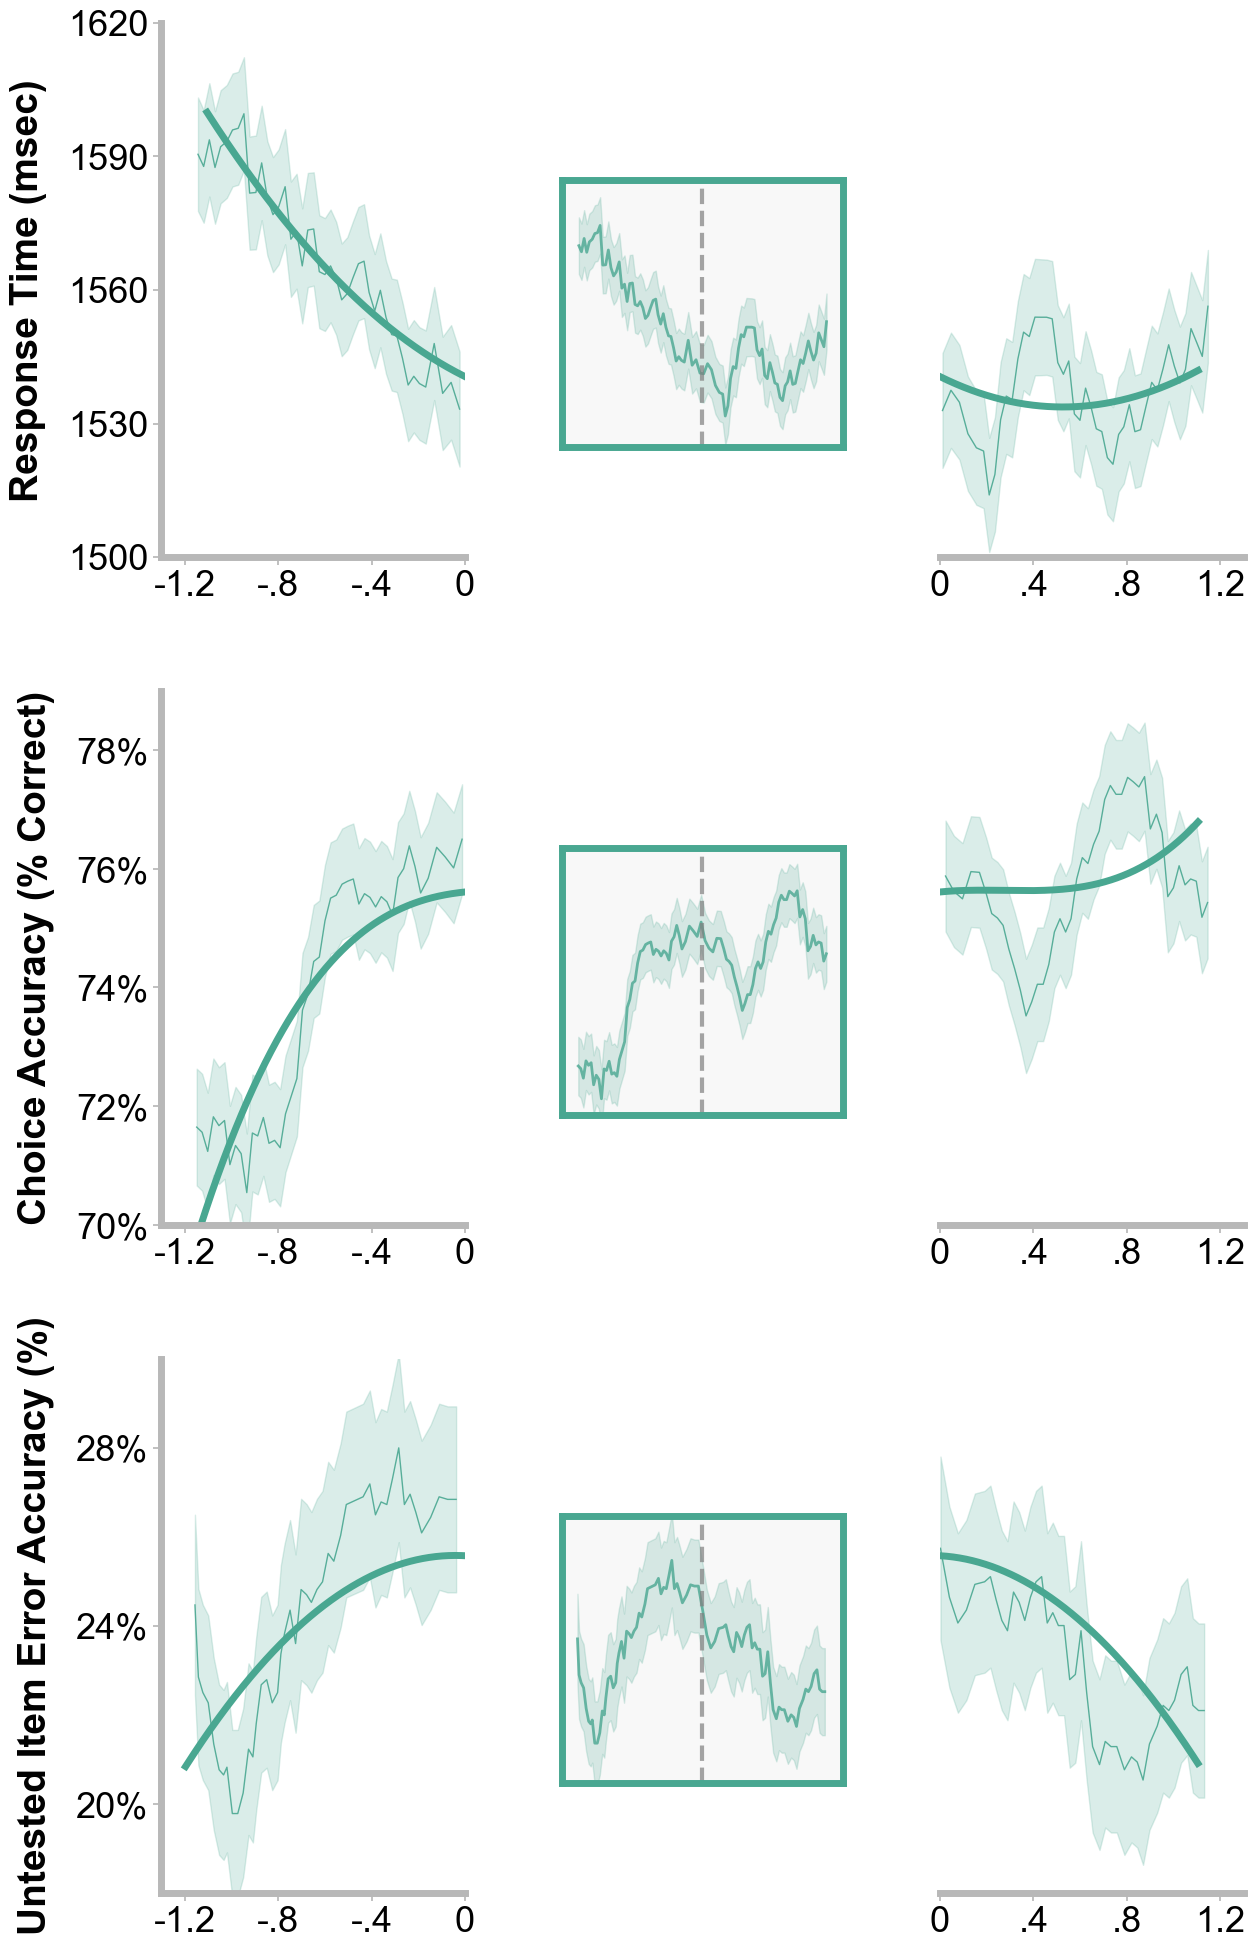

In [20]:
fig_it = create_three_panel_visualization(
    df, df_correct, df_cleaned,
    plot_configs_it,
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03
)


Using df_correct for WM RT
Full data - All Data, Total points: 60219, Window size: 6021, Step size: 602
  📊 Full data - All Data Model Fit:
     Total points: 60219
     Points used in model fit: 54230
Continuous plot using df_correct for WM RT
Total points: 60219, Window size: 6021, Step size: 602
Using df_correct for WM RT
Full data - All Data, Total points: 60219, Window size: 6021, Step size: 602
  📊 Full data - All Data Model Fit:
     Total points: 60219
     Points used in model fit: 54230
Using df for Accuracy
Full data - All Data, Total points: 80637, Window size: 8063, Step size: 806
  📊 Full data - All Data Model Fit:
     Total points: 80637
     Points used in model fit: 72649
Continuous plot using df for Accuracy
Total points: 80637, Window size: 8063, Step size: 806
Using df for Accuracy
Full data - All Data, Total points: 80637, Window size: 8063, Step size: 806
  📊 Full data - All Data Model Fit:
     Total points: 80637
     Points used in model fit: 72649
Using df_cl

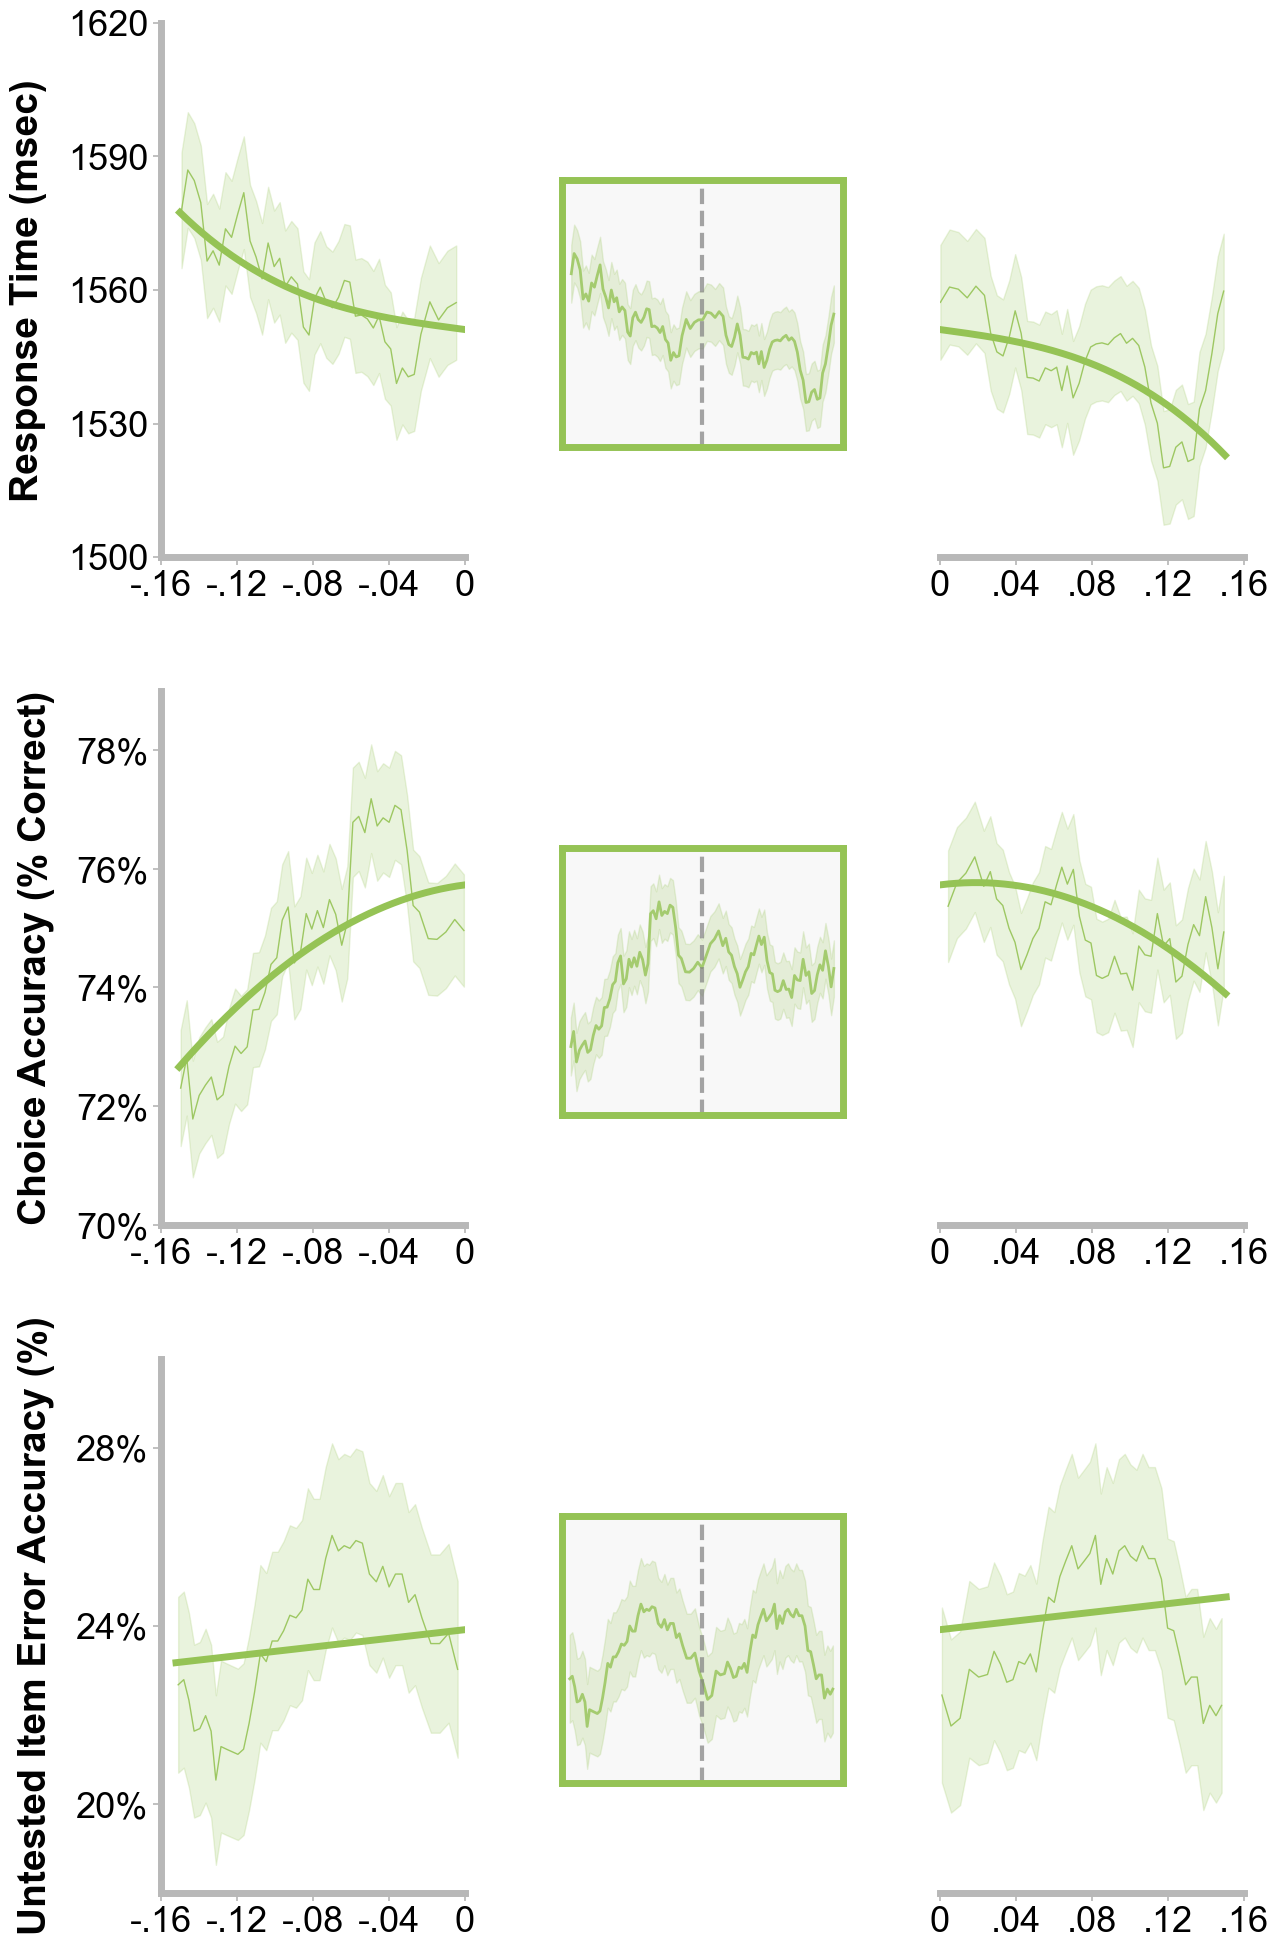

In [21]:
fig_v2 = create_three_panel_visualization(
    df, df_correct, df_cleaned,
    plot_configs_v2,
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03
)

In [22]:
df_cleaned['WM Choice Category'] 

0          wrong category
1        correct category
2        correct category
3          wrong category
4          wrong category
               ...       
17292    correct category
17293      wrong category
17294    correct category
17295    correct category
17296      wrong category
Name: WM Choice Category, Length: 17297, dtype: object

In [23]:
df_cleaned['last_clicked_category']

0        memory_distractor
1         correct_category
2         correct_category
3        memory_distractor
4        memory_distractor
               ...        
17292     correct_category
17293       wrong_category
17294     correct_category
17295     correct_category
17296    memory_distractor
Name: last_clicked_category, Length: 17297, dtype: object

In [24]:
df_cleaned['wm_category_num']

0        0
1        1
2        1
3        0
4        0
        ..
17292    1
17293    0
17294    1
17295    1
17296    0
Name: wm_category_num, Length: 17297, dtype: int64

In [25]:
df_cleaned['wm_untested_choice_num']

0        1
1        0
2        0
3        1
4        1
        ..
17292    0
17293    0
17294    0
17295    0
17296    1
Name: wm_untested_choice_num, Length: 17297, dtype: int64

In [26]:
df_cleaned['WM Wrong Category'] = np.where(
    df_cleaned['last_clicked_category'] == 'wrong_category',
    'True',
    'False'
)
df_cleaned['wm_wrong_category'] = df_cleaned['WM Wrong Category']

df_cleaned['wm_wrong_category_num'] =  np.where(
    df_cleaned['wm_wrong_category'] == "True", 1,0 )
df_cleaned['wm_wrong_category_num'].unique()


array([0, 1])

In [27]:
df_cleaned['Wrong Category'] = df_cleaned['wm_wrong_category_num']

In [28]:
df_cleaned['Wrong Category']

0        0
1        0
2        0
3        0
4        0
        ..
17292    0
17293    1
17294    0
17295    0
17296    0
Name: Wrong Category, Length: 17297, dtype: int64

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator

def remove_leading_zero_formatter(x, pos):
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def create_continuous_rolling_plot(df, df_correct, df_cleaned, x_col, y_col, item_col=None, 
                                 window_percent=0.1, step_percent=0.02,
                                 ax=None, 
                                 y_limits=None, x_limits=None,
                                 x_tick_step=None, y_tick_step=None, x_ticks=None,
                                 y_as_percentage=False, y_percentage_step=2,
                                 font_family='Arial',
                                 title_font_size=18, title_font_color='black', title_font_weight='bold',
                                 label_font_size=16, label_font_color='black', label_font_weight='bold',
                                 tick_font_size=14, tick_font_color='black',
                                 line_width=3, confidence_alpha=0.2,
                                 show_title=True):
    
    # Select the appropriate dataframe based on the y_col
    if y_col.lower() in ['wm rt', 'rt', 'reaction_time', 'response_time']:
        df = df_correct.copy()
        print(f"Continuous plot using df_correct for {y_col}")
    elif y_col.lower() in ['error category accuracy', 'error_category_accuracy', 'within_category_errors', 'untested item error accuracy', 'wrong category']:
        df = df_cleaned.copy()
        print(f"Continuous plot using df_cleaned for {y_col}")
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct', 'choice_accuracy']:
        df = df.copy()
        print(f"Continuous plot using df for {y_col}")
    else:
        # Default to main df if unclear
        df = df.copy()
        print(f"Continuous plot using default df for {y_col}")
    
    if "IT Distractor Similarity" in x_col:
        palette = ['#49a791']
    elif "V2 Distractor Similarity" in x_col:
        palette = ['#95c355']
    else:
        palette = ['#49a791']
    
    fig = combined_rolling_average_subplot(
        df=df, 
        x_col=x_col, 
        y_col=y_col, 
        item_col=item_col,
        window_percent=window_percent, 
        step_percent=step_percent,
        palette=palette,
        ax=ax, 
        show_title=False,
        show_xlabel=True,
        font_family=font_family, 
        title_font_size=title_font_size, 
        title_font_color=title_font_color, 
        title_font_weight=title_font_weight,
        label_font_size=label_font_size, 
        label_font_color=label_font_color, 
        label_font_weight=label_font_weight,
        tick_font_size=tick_font_size-2,
        tick_font_color=tick_font_color,
        y_as_percentage=y_as_percentage, 
        y_percentage_step=y_percentage_step, 
        x_tick_step=x_tick_step, 
        y_tick_step=y_tick_step,
        x_limits=x_limits, 
        y_limits=y_limits,
        x_ticks=x_ticks,
        line_width=line_width, 
        confidence_alpha=confidence_alpha
    )
    
    ax.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=3)
    
    if show_title:
        ax.set_title("Continuous", fontsize=title_font_size-2, 
                    color=title_font_color, fontweight=title_font_weight, 
                    fontfamily=font_family, pad=15)
    
    ax.set_xlabel('')
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.spines['bottom'].set_visible(False)
    
    return ax


def create_single_side_plot_with_full_fit(df, df_correct, df_cleaned, x_col, y_col, item_col=None, 
                                         split_col='v2_pos_neg', split_value=0, side='left',
                                         window_percent=0.1, step_percent=0.01,
                                         ax=None, palette=None,
                                         y_limits=None, x_limits=None,
                                         x_tick_step=None, y_tick_step=None,
                                         model_order=2, trim_percentile=0,
                                         y_as_percentage=False, y_percentage_step=2,
                                         font_family='Arial',
                                         title_font_size=18, title_font_color='black', title_font_weight='bold',
                                         label_font_size=16, label_font_color='black', label_font_weight='bold',
                                         tick_font_size=14, tick_font_color='black',
                                         rolling_line_width=1, model_line_width=5,
                                         confidence_alpha=0.2, rolling_alpha=0.9,
                                         show_title=True, show_ylabel=True, show_xlabel=True):
    
    # Select the appropriate dataframe based on the y_col
    if y_col.lower() in ['wm rt', 'rt', 'reaction_time', 'response_time']:
        df = df_correct.copy()
        print(f"Using df_correct for {y_col}")
    elif y_col.lower() in ['error category accuracy', 'error_category_accuracy', 'within_category_errors', 'untested item error accuracy', 'wrong category']:
        df = df_cleaned.copy()
        print(f"Using df_cleaned for {y_col}")
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct', 'choice_accuracy']:
        df = df.copy()
        print(f"Using df for {y_col}")
    else:
        # Default to main df if unclear
        df = df.copy()
        print(f"Using default df for {y_col}")
    
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
    if palette is None:
        if "IT Distractor Similarity" in x_col:
            default_colors = [teal, grey]
        elif "V2 Distractor Similarity" in x_col:
            default_colors = [green, grey]
        else:
            default_colors = [teal, grey]
    else:
        default_colors = palette
    
    color_map = {
        'prioritized': default_colors[0],    
        'deprioritized': default_colors[1] if len(default_colors) > 1 else grey,  
    }
    
    # Define the side data for display limits
    if side == 'left':
        df_side = df[df[x_col] <= split_value].copy()
        title_text = f"{x_col} ≤ {split_value}"
    else:
        df_side = df[df[x_col] > split_value].copy()
        title_text = f"{x_col} > {split_value}"
    
    ax.set_facecolor('white')
    
    item_color_dict = {}
    if item_col is not None and item_col in df.columns:
        all_items = df[item_col].unique()
        for i, item in enumerate(all_items):
            item_lower = str(item).lower()
            if item_lower in color_map:
                item_color_dict[item] = color_map[item_lower]
            elif 'prioritized' in item_lower:
                item_color_dict[item] = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                item_color_dict[item] = color_map['deprioritized']
            else:
                item_color_dict[item] = default_colors[i % len(default_colors)]
    
    if item_col is not None and item_col in df.columns:
        items = df[item_col].unique()
        
        # FIRST: Create rolling averages for the FULL dataset for each item
        full_rolling_data = {}
        for i, item in enumerate(items):
            df_item_full = df[df[item_col] == item].copy()
            df_item_full = df_item_full.sort_values(by=x_col).reset_index(drop=True)
            total_points_full = len(df_item_full)
            
            window_points = max(int(total_points_full * window_percent), 3)
            step_points = max(int(total_points_full * step_percent), 1)
            color = item_color_dict.get(item, default_colors[i % len(default_colors)])
            
            if total_points_full >= window_points:
                print(f"Full data - {item}, Total points: {total_points_full}, "
                      f"Window size: {window_points}, Step size: {step_points}")
                
                x_vals, y_vals, y_errs = [], [], []
                for j in range(0, total_points_full - window_points + 1, step_points):
                    window = df_item_full.iloc[j:j+window_points]
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    std_y = window[y_col].std()
                    sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                    x_vals.append(mean_x)
                    y_vals.append(mean_y)
                    y_errs.append(sem_y)
                
                full_rolling_data[item] = {
                    'x_vals': np.array(x_vals),
                    'y_vals': np.array(y_vals),
                    'y_errs': np.array(y_errs),
                    'color': color
                }
        
        # SECOND: Plot rolling averages (only the portion for this side)
        for item in items:
            if item in full_rolling_data:
                data = full_rolling_data[item]
                x_vals, y_vals, y_errs = data['x_vals'], data['y_vals'], data['y_errs']
                color = data['color']
                
                # Filter to only show the side we want
                if side == 'left':
                    mask = x_vals <= split_value
                else:
                    mask = x_vals > split_value
                
                if np.any(mask):
                    x_side = x_vals[mask]
                    y_side = y_vals[mask]
                    y_err_side = y_errs[mask]
                    
                    ax.plot(x_side, y_side, color=color, linewidth=rolling_line_width, 
                           alpha=rolling_alpha, label=f'{item} (rolling)')
                    ax.fill_between(x_side, 
                                   y_side - 1.96 * y_err_side,
                                   y_side + 1.96 * y_err_side,
                                   color=color, alpha=confidence_alpha)
        
        # THIRD: Create model fits for the FULL dataset for each item
        for i, item in enumerate(items):
            df_item_full = df[df[item_col] == item].copy()
            
            if trim_percentile > 0:
                lower_p = np.percentile(df_item_full[x_col], trim_percentile)
                upper_p = np.percentile(df_item_full[x_col], 100 - trim_percentile)
                df_item_trimmed = df_item_full[(df_item_full[x_col] >= lower_p) & (df_item_full[x_col] <= upper_p)]
            else:
                df_item_trimmed = df_item_full
                
            total_points = len(df_item_trimmed)
            color = item_color_dict.get(item, default_colors[i % len(default_colors)])
            
            if total_points >= 5:
                total_points_full = len(df_item_full)
                window_points_full = max(int(total_points_full * window_percent), 3)
                
                # Use full dataset for rolling constraints
                df_item_sorted = df_item_full.sort_values(by=x_col)
                rolling_min_x = df_item_sorted.iloc[window_points_full//2][x_col]
                rolling_max_x = df_item_sorted.iloc[-(window_points_full//2 + 1)][x_col]
                
                # Model fit range based on full data constraints
                model_min_x = max(df_item_trimmed[x_col].min(), rolling_min_x)
                model_max_x = min(df_item_trimmed[x_col].max(), rolling_max_x)
                
                points_in_model = len(df_item_trimmed[
                    (df_item_trimmed[x_col] >= model_min_x) & 
                    (df_item_trimmed[x_col] <= model_max_x)
                ])
                
                print(f"  📊 Full data - {item} Model Fit:")
                print(f"     Total points: {len(df_item_full)}")
                print(f"     Points used in model fit: {points_in_model}")
                
                if model_max_x > model_min_x:
                    # Fit model to full data within constraints
                    model_data = df_item_trimmed[
                        (df_item_trimmed[x_col] >= model_min_x) & 
                        (df_item_trimmed[x_col] <= model_max_x)
                    ]
                    
                    if len(model_data) >= 5:
                        model = np.poly1d(np.polyfit(model_data[x_col], model_data[y_col], model_order))
                        
                        # Create x range for the full model, but only plot the side we want
                        full_x_range = np.linspace(model_min_x, model_max_x, 1000)
                        
                        if side == 'left':
                            side_mask = full_x_range <= split_value
                        else:
                            side_mask = full_x_range > split_value
                        
                        if np.any(side_mask):
                            side_x_range = full_x_range[side_mask]
                            if len(side_x_range) > 0:
                                ax.plot(side_x_range, model(side_x_range), color=color, linestyle='-', 
                                        linewidth=model_line_width, label=f'{item} (model)')
    else:
        # Handle case without item_col - fit to full data
        df_full = df.copy().sort_values(by=x_col).reset_index(drop=True)
        total_points_full = len(df_full)
        
        window_points = max(int(total_points_full * window_percent), 3)
        step_points = max(int(total_points_full * step_percent), 1)
        color = default_colors[0]
        
        # Rolling average for full data
        if total_points_full >= window_points:
            print(f"Full data - All Data, Total points: {total_points_full}, "
                  f"Window size: {window_points}, Step size: {step_points}")
            
            x_vals, y_vals, y_errs = [], [], []
            for j in range(0, total_points_full - window_points + 1, step_points):
                window = df_full.iloc[j:j+window_points]
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                x_vals.append(mean_x)
                y_vals.append(mean_y)
                y_errs.append(sem_y)
            
            x_vals = np.array(x_vals)
            y_vals = np.array(y_vals)
            y_errs = np.array(y_errs)
            
            # Filter to side
            if side == 'left':
                mask = x_vals <= split_value
            else:
                mask = x_vals > split_value
            
            if np.any(mask):
                x_side = x_vals[mask]
                y_side = y_vals[mask]
                y_err_side = y_errs[mask]
                
                ax.plot(x_side, y_side, color=color, linewidth=rolling_line_width, 
                       alpha=rolling_alpha, label='Rolling average')
                ax.fill_between(x_side, 
                               y_side - 1.96 * y_err_side,
                               y_side + 1.96 * y_err_side,
                               color=color, alpha=confidence_alpha)
        
        # Model fit for full data
        if trim_percentile > 0:
            lower_p = np.percentile(df_full[x_col], trim_percentile)
            upper_p = np.percentile(df_full[x_col], 100 - trim_percentile)
            df_trimmed = df_full[(df_full[x_col] >= lower_p) & (df_full[x_col] <= upper_p)]
        else:
            df_trimmed = df_full
            
        total_points_trimmed = len(df_trimmed)
        
        if total_points_trimmed >= 5:
            window_points_full = max(int(total_points_full * window_percent), 3)
            
            df_sorted = df_full.sort_values(by=x_col)
            rolling_min_x = df_sorted.iloc[window_points_full//2][x_col]
            rolling_max_x = df_sorted.iloc[-(window_points_full//2 + 1)][x_col]
            
            model_min_x = max(df_trimmed[x_col].min(), rolling_min_x)
            model_max_x = min(df_trimmed[x_col].max(), rolling_max_x)
            
            points_in_model = len(df_trimmed[
                (df_trimmed[x_col] >= model_min_x) & 
                (df_trimmed[x_col] <= model_max_x)
            ])
            
            print(f"  📊 Full data - All Data Model Fit:")
            print(f"     Total points: {len(df_full)}")
            print(f"     Points used in model fit: {points_in_model}")
            
            if model_max_x > model_min_x:
                model_data = df_trimmed[
                    (df_trimmed[x_col] >= model_min_x) & 
                    (df_trimmed[x_col] <= model_max_x)
                ]
                
                if len(model_data) >= 5:
                    model = np.poly1d(np.polyfit(model_data[x_col], model_data[y_col], model_order))
                    
                    full_x_range = np.linspace(model_min_x, model_max_x, 1000)
                    
                    if side == 'left':
                        side_mask = full_x_range <= split_value
                    else:
                        side_mask = full_x_range > split_value
                    
                    if np.any(side_mask):
                        side_x_range = full_x_range[side_mask]
                        if len(side_x_range) > 0:
                            ax.plot(side_x_range, model(side_x_range), color=color, linestyle='-', 
                                    linewidth=model_line_width, label='Model fit')
    
    # Rest of the formatting code with updated y-axis labeling...
    if show_title:
        if side == 'left':
            ax.set_title("Negative", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
        else:
            ax.set_title("Positive", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
    
    if show_xlabel:
        if x_col in ["Tested - Untested IT Distractor Similarity"]:
            ax.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif x_col in ["Tested - Untested V2 Distractor Similarity"]:
            ax.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_xlabel(x_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    else:
        ax.set_xlabel('')
    
    if show_ylabel:
        if y_col.lower() in ['accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['wm rt']:
            ax.set_ylabel("Response Time (msec)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['error category accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Within Category Errors (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Within Category Errors", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['untested item error accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Untested Item Error Accuracy (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Untested Item Error Accuracy", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['wrong category']:
            if y_as_percentage:
                ax.set_ylabel("Wrong Category Errors (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Wrong Category Errors", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_ylabel(y_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    if x_limits is not None:
        if side == 'left':
            ax.set_xlim(x_limits[0], split_value)
        else:
            ax.set_xlim(split_value, x_limits[1])
    if y_limits is not None:
        ax.set_ylim(y_limits)
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct']:
        ax.set_ylim(0.6, 0.8)
    
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    spine_color = '#B8B8B8'
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['left'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.grid(False)
    
    return ax

def create_three_panel_visualization(df, df_correct, df_cleaned, plot_configs, middle_width=0.35, middle_height_shift=0.0, middle_size_scale=0.7, adjustable_gap=0.01):
    
    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=(18, 22))
    
    # Keep plot sizes FIXED regardless of gap size
    # Calculate what the original sizes were with gap_width = 0.01
    original_gap_width = 0.01
    original_remaining_width = 1.0 - middle_width - 2*original_gap_width
    fixed_side_width = original_remaining_width / 2 * 0.6  # This stays constant
    fixed_middle_width = middle_width  # This stays constant
    
    # Only the gap changes
    current_gap_width = adjustable_gap
    
    # Adjust outer margins to accommodate the gap change
    total_plot_width = 2 * fixed_side_width + fixed_middle_width + 2 * current_gap_width
    remaining_for_margins = 1.0 - total_plot_width
    outer_margin = remaining_for_margins / 2
    
    # Ensure margins don't go negative
    if outer_margin < 0.001:
        outer_margin = 0.001
    
    gs = GridSpec(3, 7, figure=fig, 
                  width_ratios=[outer_margin, fixed_side_width, current_gap_width, fixed_middle_width, current_gap_width, fixed_side_width, outer_margin],  
                  height_ratios=[1, 1, 1],   
                  hspace=0.25, wspace=0.01,
                  top=0.95, bottom=0.1, left=0.05, right=0.95)
    axes = []
    for row in range(3):
        ax_left = fig.add_subplot(gs[row, 1])
        ax_middle = fig.add_subplot(gs[row, 3])
        ax_right = fig.add_subplot(gs[row, 5])
        axes.append([ax_left, ax_middle, ax_right])

    all_handles = []
    all_labels = []
    
    for row, config in enumerate(plot_configs):
        x_col = config['x_col']
        if "IT Distractor Similarity" in x_col:
            frame_color = '#49a791'
            # IT model orders: 3,3,2 for rows 0,1,2
            if row == 0:
                current_model_order = 3
            elif row == 1:
                current_model_order = 3
            elif row == 2:
                current_model_order = 2
            else:
                current_model_order = 2  # fallback
        elif "V2 Distractor Similarity" in x_col:
            frame_color = '#95c355'
            # V2 model orders: 3,2,1 for rows 0,1,2
            if row == 0:
                current_model_order = 3
            elif row == 1:
                current_model_order = 2
            elif row == 2:
                current_model_order = 1
            else:
                current_model_order = 2  # fallback
        else:
            frame_color = '#49a791'
            current_model_order = 2  # fallback
        
        y_limits = config.get('y_limits')
        
        # Use the new function with full data fitting
        create_single_side_plot_with_full_fit(
            df, df_correct, df_cleaned,
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            side='left',
            ax=axes[row][0],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            model_order=current_model_order,  # Use the determined model order
            trim_percentile=config.get('trim_percentile', 0),
            window_percent=0.1,  # Updated to 0.1
            step_percent=0.01,   # Updated to 0.01
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 16),
            tick_font_size=config.get('tick_font_size', 14),
            show_title=False,
            show_ylabel=True,
            show_xlabel=False
        )
        
        axes[row][0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        
        create_continuous_rolling_plot(
            df, df_correct, df_cleaned,
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            ax=axes[row][1],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            x_ticks=config.get('x_ticks'),
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 14),
            tick_font_size=config.get('tick_font_size', 12),
            window_percent=0.1,
            step_percent = 0.01,
            line_width=2,
            show_title=False
        )
        
        axes[row][1].set_xlabel('')
        axes[row][1].tick_params(axis='x', bottom=False, labelbottom=False)
        axes[row][1].spines['bottom'].set_visible(False)
        
        for spine_name, spine in axes[row][1].spines.items():
            spine.set_visible(True)
            spine.set_linewidth(5)
            spine.set_color(frame_color)
        
        axes[row][1].set_facecolor('#f8f8f8')
        
        pos = axes[row][1].get_position()
        new_width = pos.width * middle_size_scale
        new_height = pos.height * middle_size_scale
        new_x = pos.x0 + (pos.width - new_width) / 2
        new_y = pos.y0 + middle_height_shift
        
        new_pos = [new_x, new_y, new_width, new_height]
        axes[row][1].set_position(new_pos)
        
        # Use the new function with full data fitting
        create_single_side_plot_with_full_fit(
            df, df_correct, df_cleaned,
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            side='right',
            ax=axes[row][2],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            model_order=current_model_order,  # Use the same determined model order
            trim_percentile=config.get('trim_percentile', 0),
            window_percent=0.1,  # Updated to 0.1
            step_percent=0.01,   # Updated to 0.01
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 16),
            tick_font_size=config.get('tick_font_size', 14),
            show_title=False,
            show_ylabel=False,
            show_xlabel=False
        )
        
        axes[row][2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        
        axes[row][1].set_ylabel('')
        axes[row][1].tick_params(axis='y', labelleft=False, left=False)
        
        axes[row][2].set_ylabel('')
        axes[row][2].tick_params(axis='y', labelleft=False, left=False)
        axes[row][2].spines['left'].set_visible(False)
        
        # Legend collection code removed since legend is disabled
        
        axes[row][0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        axes[row][2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Legend removed as requested
    # if all_handles:
    #     fig.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 0.02), 
    #                ncol=len(all_labels), frameon=True, fontsize=12)
    
    plt.show()
    return fig


In [30]:
plot_configs_v2 = [
    {
        'df': df_correct,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None,
        'y_limits': (1500, 1620),
        'y_tick_step': 30,
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 1,
        'right_model_order': 2,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'y_limits': (0.7, 0.79),
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df_cleaned,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "Wrong Category",
        'item_col': None,
        'y_limits': (0.1, 0.2),
        'y_tick_step': 0.04,
        'y_as_percentage': True,
        'y_percentage_step': 4,
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    }
]

plot_configs_it = [
    {
        'df': df_correct,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None,
        'y_limits': (1500, 1620),
        'y_tick_step': 30,
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 2,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'y_limits': (0.7, 0.79),
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df_cleaned,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Wrong Category",
        'item_col': None,
        'y_limits': (0.1, 0.2),
        'y_tick_step': 0.04,
        'y_as_percentage': True,
        'y_percentage_step': 4,
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 1,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    }
]

Using df_correct for WM RT
Full data - All Data, Total points: 60219, Window size: 6021, Step size: 602
  📊 Full data - All Data Model Fit:
     Total points: 60219
     Points used in model fit: 54219
Continuous plot using df_correct for WM RT
Total points: 60219, Window size: 6021, Step size: 602
Using df_correct for WM RT
Full data - All Data, Total points: 60219, Window size: 6021, Step size: 602
  📊 Full data - All Data Model Fit:
     Total points: 60219
     Points used in model fit: 54219
Using df for Accuracy
Full data - All Data, Total points: 80637, Window size: 8063, Step size: 806
  📊 Full data - All Data Model Fit:
     Total points: 80637
     Points used in model fit: 72625
Continuous plot using df for Accuracy
Total points: 80637, Window size: 8063, Step size: 806
Using df for Accuracy
Full data - All Data, Total points: 80637, Window size: 8063, Step size: 806
  📊 Full data - All Data Model Fit:
     Total points: 80637
     Points used in model fit: 72625
Using df_cl

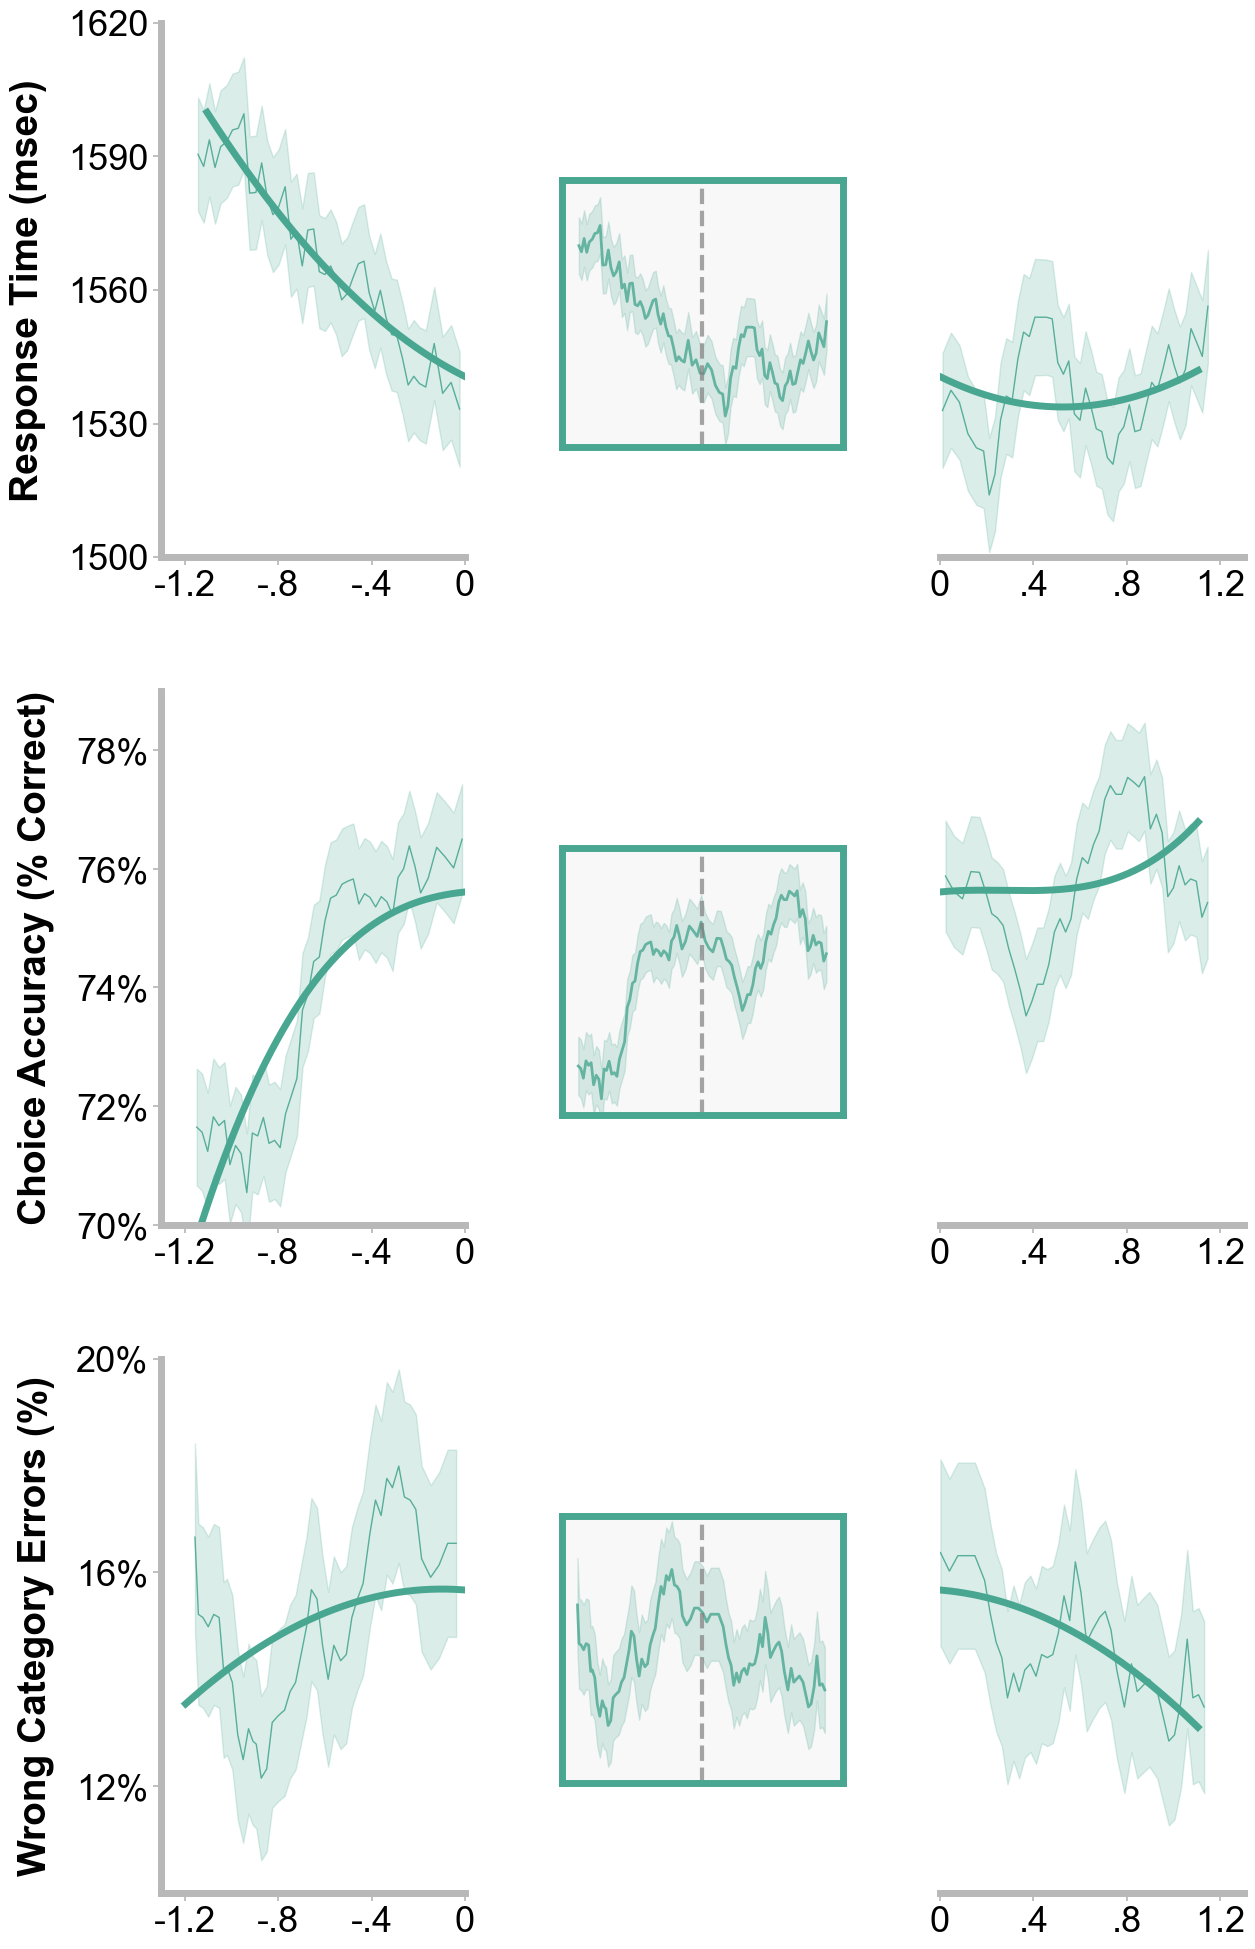

In [31]:
fig_it = create_three_panel_visualization(
    df, df_correct, df_cleaned,
    plot_configs_it,
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03
)



Using df_correct for WM RT
Full data - All Data, Total points: 60219, Window size: 6021, Step size: 602
  📊 Full data - All Data Model Fit:
     Total points: 60219
     Points used in model fit: 54230
Continuous plot using df_correct for WM RT
Total points: 60219, Window size: 6021, Step size: 602
Using df_correct for WM RT
Full data - All Data, Total points: 60219, Window size: 6021, Step size: 602
  📊 Full data - All Data Model Fit:
     Total points: 60219
     Points used in model fit: 54230
Using df for Accuracy
Full data - All Data, Total points: 80637, Window size: 8063, Step size: 806
  📊 Full data - All Data Model Fit:
     Total points: 80637
     Points used in model fit: 72649
Continuous plot using df for Accuracy
Total points: 80637, Window size: 8063, Step size: 806
Using df for Accuracy
Full data - All Data, Total points: 80637, Window size: 8063, Step size: 806
  📊 Full data - All Data Model Fit:
     Total points: 80637
     Points used in model fit: 72649
Using df_cl

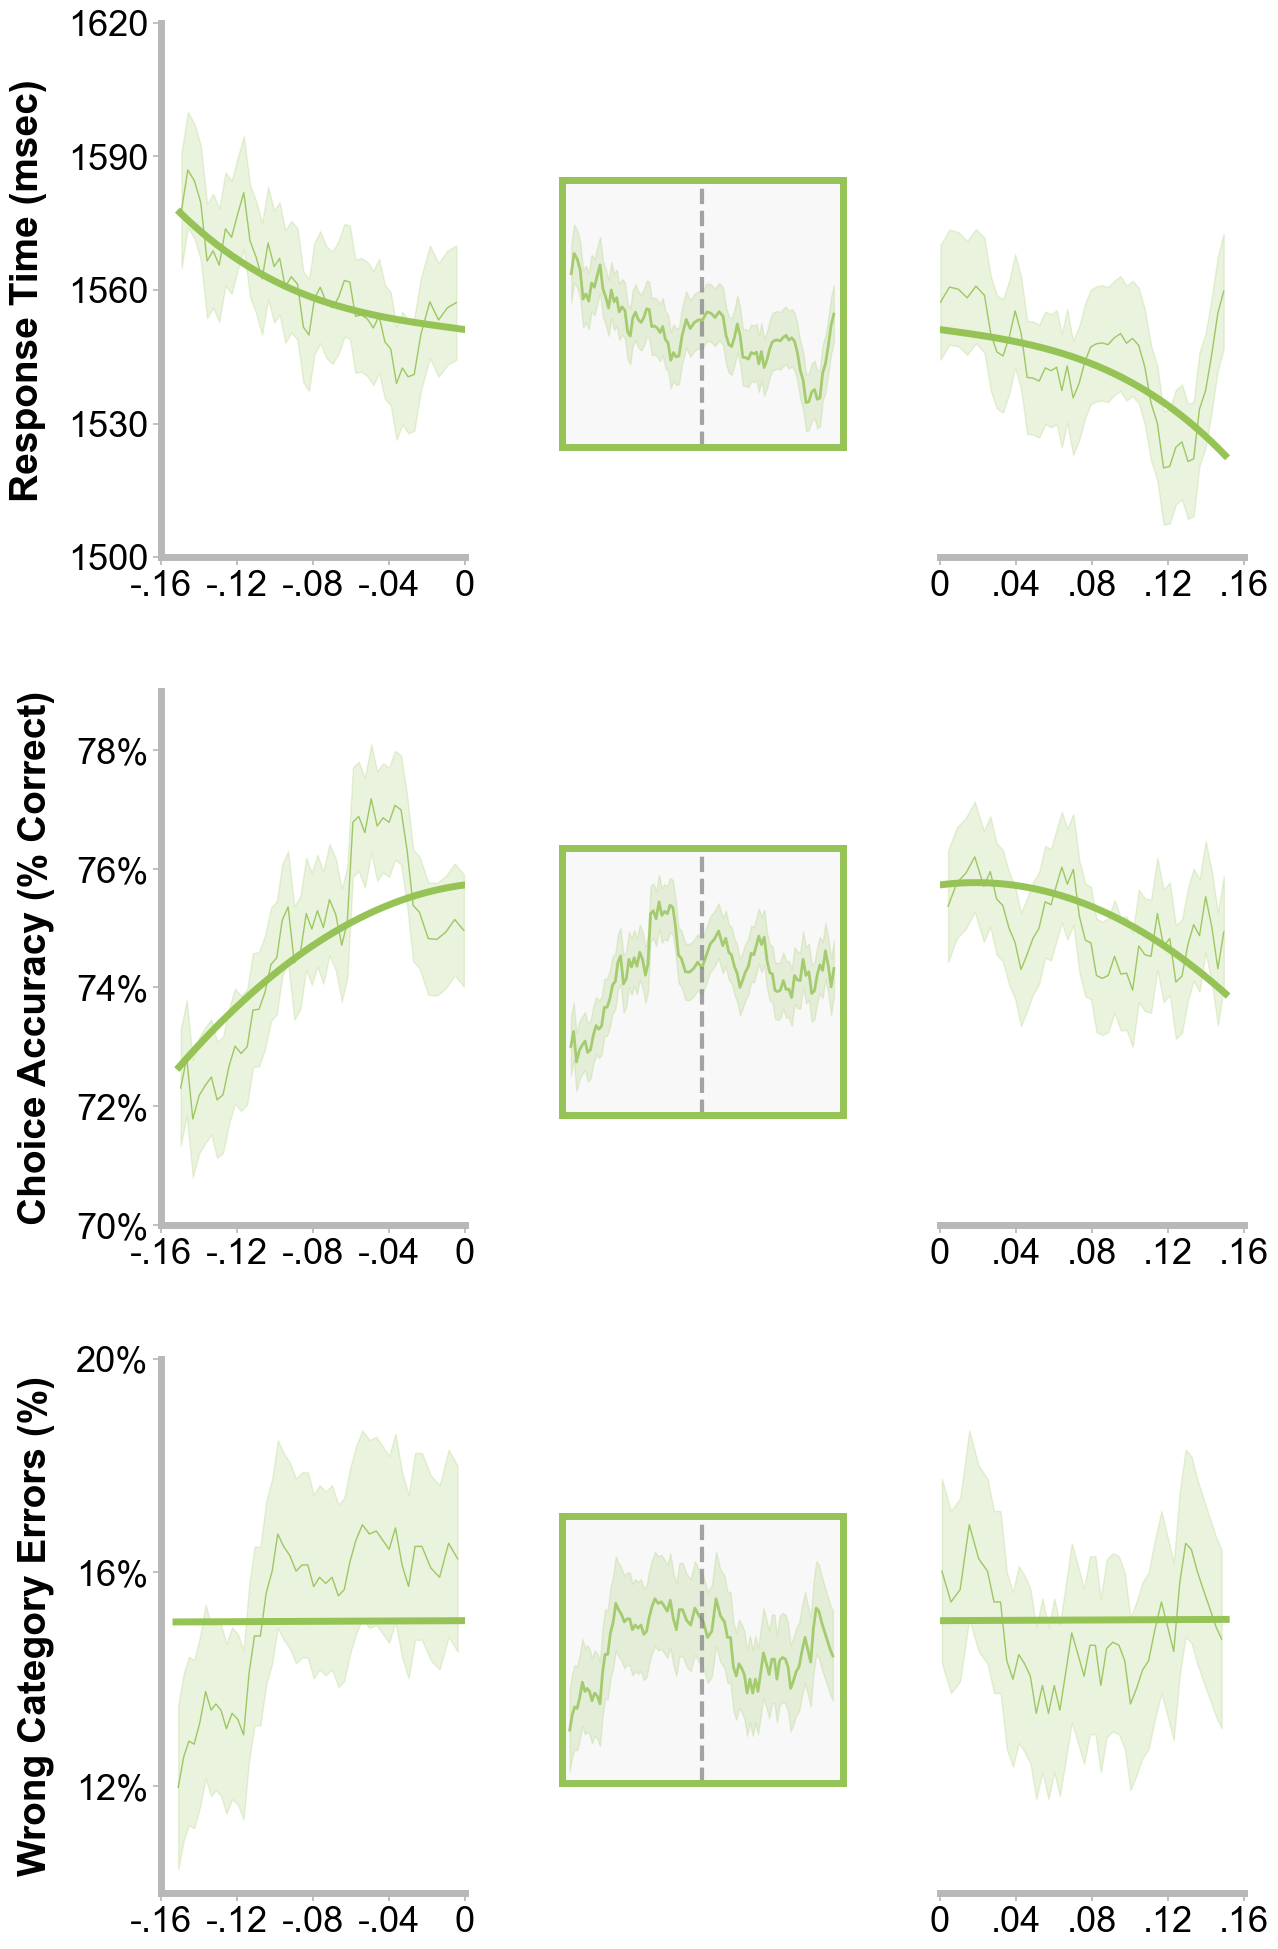

In [32]:
fig_v2 = create_three_panel_visualization(
    df, df_correct, df_cleaned,
    plot_configs_v2,
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03
)

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator

def remove_leading_zero_formatter(x, pos):
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def create_continuous_rolling_plot(df, df_correct, df_cleaned, x_col, y_col, item_col=None, 
                                 window_percent=0.1, step_percent=0.02,
                                 ax=None, 
                                 y_limits=None, x_limits=None,
                                 x_tick_step=None, y_tick_step=None, x_ticks=None,
                                 y_as_percentage=False, y_percentage_step=2,
                                 font_family='Arial',
                                 title_font_size=18, title_font_color='black', title_font_weight='bold',
                                 label_font_size=16, label_font_color='black', label_font_weight='bold',
                                 tick_font_size=14, tick_font_color='black',
                                 line_width=3, confidence_alpha=0.2,
                                 show_title=True):
    
    # Select the appropriate dataframe based on the y_col
    if y_col.lower() in ['wm rt', 'rt', 'reaction_time', 'response_time']:
        df = df_correct.copy()
        print(f"Continuous plot using df_correct for {y_col}")
    elif y_col.lower() in ['error category accuracy', 'error_category_accuracy', 'within_category_errors', 'untested item error accuracy', 'wrong category']:
        df = df_cleaned.copy()
        print(f"Continuous plot using df_cleaned for {y_col}")
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct', 'choice_accuracy']:
        df = df.copy()
        print(f"Continuous plot using df for {y_col}")
    else:
        # Default to main df if unclear
        df = df.copy()
        print(f"Continuous plot using default df for {y_col}")
    
    if "IT Distractor Similarity" in x_col:
        palette = ['#49a791']
    elif "V2 Distractor Similarity" in x_col:
        palette = ['#95c355']
    else:
        palette = ['#49a791']
    
    fig = combined_rolling_average_subplot(
        df=df, 
        x_col=x_col, 
        y_col=y_col, 
        item_col=item_col,
        window_percent=window_percent, 
        step_percent=step_percent,
        palette=palette,
        ax=ax, 
        show_title=False,
        show_xlabel=True,
        font_family=font_family, 
        title_font_size=title_font_size, 
        title_font_color=title_font_color, 
        title_font_weight=title_font_weight,
        label_font_size=label_font_size, 
        label_font_color=label_font_color, 
        label_font_weight=label_font_weight,
        tick_font_size=tick_font_size-2,
        tick_font_color=tick_font_color,
        y_as_percentage=y_as_percentage, 
        y_percentage_step=y_percentage_step, 
        x_tick_step=x_tick_step, 
        y_tick_step=y_tick_step,
        x_limits=x_limits, 
        y_limits=y_limits,
        x_ticks=x_ticks,
        line_width=line_width, 
        confidence_alpha=confidence_alpha
    )
    
    ax.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=3)
    
    if show_title:
        ax.set_title("Continuous", fontsize=title_font_size-2, 
                    color=title_font_color, fontweight=title_font_weight, 
                    fontfamily=font_family, pad=15)
    
    ax.set_xlabel('')
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.spines['bottom'].set_visible(False)
    
    return ax


def create_single_side_plot_with_full_fit(df, df_correct, df_cleaned, x_col, y_col, item_col=None, 
                                         split_col='v2_pos_neg', split_value=0, side='left',
                                         window_percent=0.1, step_percent=0.01,
                                         ax=None, palette=None,
                                         y_limits=None, x_limits=None,
                                         x_tick_step=None, y_tick_step=None,
                                         model_order=2, trim_percentile=0,
                                         y_as_percentage=False, y_percentage_step=2,
                                         font_family='Arial',
                                         title_font_size=18, title_font_color='black', title_font_weight='bold',
                                         label_font_size=16, label_font_color='black', label_font_weight='bold',
                                         tick_font_size=14, tick_font_color='black',
                                         rolling_line_width=1, model_line_width=5,
                                         confidence_alpha=0.2, rolling_alpha=0.9,
                                         show_title=True, show_ylabel=True, show_xlabel=True):
    
    # Select the appropriate dataframe based on the y_col
    if y_col.lower() in ['wm rt', 'rt', 'reaction_time', 'response_time']:
        df = df_correct.copy()
        print(f"Using df_correct for {y_col}")
    elif y_col.lower() in ['error category accuracy', 'error_category_accuracy', 'within_category_errors', 'untested item error accuracy', 'wrong category']:
        df = df_cleaned.copy()
        print(f"Using df_cleaned for {y_col}")
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct', 'choice_accuracy']:
        df = df.copy()
        print(f"Using df for {y_col}")
    else:
        # Default to main df if unclear
        df = df.copy()
        print(f"Using default df for {y_col}")
    
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
    if palette is None:
        if "IT Distractor Similarity" in x_col:
            default_colors = [teal, grey]
        elif "V2 Distractor Similarity" in x_col:
            default_colors = [green, grey]
        else:
            default_colors = [teal, grey]
    else:
        default_colors = palette
    
    color_map = {
        'prioritized': default_colors[0],    
        'deprioritized': default_colors[1] if len(default_colors) > 1 else grey,  
    }
    
    # Define the side data for display limits
    if side == 'left':
        df_side = df[df[x_col] <= split_value].copy()
        title_text = f"{x_col} ≤ {split_value}"
    else:
        df_side = df[df[x_col] > split_value].copy()
        title_text = f"{x_col} > {split_value}"
    
    ax.set_facecolor('white')
    
    item_color_dict = {}
    if item_col is not None and item_col in df.columns:
        all_items = df[item_col].unique()
        for i, item in enumerate(all_items):
            item_lower = str(item).lower()
            if item_lower in color_map:
                item_color_dict[item] = color_map[item_lower]
            elif 'prioritized' in item_lower:
                item_color_dict[item] = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                item_color_dict[item] = color_map['deprioritized']
            else:
                item_color_dict[item] = default_colors[i % len(default_colors)]
    
    if item_col is not None and item_col in df.columns:
        items = df[item_col].unique()
        
        # FIRST: Create rolling averages for the FULL dataset for each item
        full_rolling_data = {}
        for i, item in enumerate(items):
            df_item_full = df[df[item_col] == item].copy()
            df_item_full = df_item_full.sort_values(by=x_col).reset_index(drop=True)
            total_points_full = len(df_item_full)
            
            window_points = max(int(total_points_full * window_percent), 3)
            step_points = max(int(total_points_full * step_percent), 1)
            color = item_color_dict.get(item, default_colors[i % len(default_colors)])
            
            if total_points_full >= window_points:
                print(f"Full data - {item}, Total points: {total_points_full}, "
                      f"Window size: {window_points}, Step size: {step_points}")
                
                x_vals, y_vals, y_errs = [], [], []
                for j in range(0, total_points_full - window_points + 1, step_points):
                    window = df_item_full.iloc[j:j+window_points]
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    std_y = window[y_col].std()
                    sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                    x_vals.append(mean_x)
                    y_vals.append(mean_y)
                    y_errs.append(sem_y)
                
                full_rolling_data[item] = {
                    'x_vals': np.array(x_vals),
                    'y_vals': np.array(y_vals),
                    'y_errs': np.array(y_errs),
                    'color': color
                }
        
        # SECOND: Plot rolling averages (only the portion for this side)
        for item in items:
            if item in full_rolling_data:
                data = full_rolling_data[item]
                x_vals, y_vals, y_errs = data['x_vals'], data['y_vals'], data['y_errs']
                color = data['color']
                
                # Filter to only show the side we want
                if side == 'left':
                    mask = x_vals <= split_value
                else:
                    mask = x_vals > split_value
                
                if np.any(mask):
                    x_side = x_vals[mask]
                    y_side = y_vals[mask]
                    y_err_side = y_errs[mask]
                    
                    ax.plot(x_side, y_side, color=color, linewidth=rolling_line_width, 
                           alpha=rolling_alpha, label=f'{item} (rolling)')
                    ax.fill_between(x_side, 
                                   y_side - 1.96 * y_err_side,
                                   y_side + 1.96 * y_err_side,
                                   color=color, alpha=confidence_alpha)
        
        # THIRD: Create model fits for the FULL dataset for each item
        for i, item in enumerate(items):
            df_item_full = df[df[item_col] == item].copy()
            
            if trim_percentile > 0:
                lower_p = np.percentile(df_item_full[x_col], trim_percentile)
                upper_p = np.percentile(df_item_full[x_col], 100 - trim_percentile)
                df_item_trimmed = df_item_full[(df_item_full[x_col] >= lower_p) & (df_item_full[x_col] <= upper_p)]
            else:
                df_item_trimmed = df_item_full
                
            total_points = len(df_item_trimmed)
            color = item_color_dict.get(item, default_colors[i % len(default_colors)])
            
            if total_points >= 5:
                total_points_full = len(df_item_full)
                window_points_full = max(int(total_points_full * window_percent), 3)
                
                # Use full dataset for rolling constraints
                df_item_sorted = df_item_full.sort_values(by=x_col)
                rolling_min_x = df_item_sorted.iloc[window_points_full//2][x_col]
                rolling_max_x = df_item_sorted.iloc[-(window_points_full//2 + 1)][x_col]
                
                # Model fit range based on full data constraints
                model_min_x = max(df_item_trimmed[x_col].min(), rolling_min_x)
                model_max_x = min(df_item_trimmed[x_col].max(), rolling_max_x)
                
                points_in_model = len(df_item_trimmed[
                    (df_item_trimmed[x_col] >= model_min_x) & 
                    (df_item_trimmed[x_col] <= model_max_x)
                ])
                
                print(f"  📊 Full data - {item} Model Fit:")
                print(f"     Total points: {len(df_item_full)}")
                print(f"     Points used in model fit: {points_in_model}")
                
                if model_max_x > model_min_x:
                    # Fit model to full data within constraints
                    model_data = df_item_trimmed[
                        (df_item_trimmed[x_col] >= model_min_x) & 
                        (df_item_trimmed[x_col] <= model_max_x)
                    ]
                    
                    if len(model_data) >= 5:
                        model = np.poly1d(np.polyfit(model_data[x_col], model_data[y_col], model_order))
                        
                        # Create x range for the full model, but only plot the side we want
                        full_x_range = np.linspace(model_min_x, model_max_x, 1000)
                        
                        if side == 'left':
                            side_mask = full_x_range <= split_value
                        else:
                            side_mask = full_x_range > split_value
                        
                        if np.any(side_mask):
                            side_x_range = full_x_range[side_mask]
                            if len(side_x_range) > 0:
                                ax.plot(side_x_range, model(side_x_range), color=color, linestyle='-', 
                                        linewidth=model_line_width, label=f'{item} (model)')
    else:
        # Handle case without item_col - fit to full data
        df_full = df.copy().sort_values(by=x_col).reset_index(drop=True)
        total_points_full = len(df_full)
        
        window_points = max(int(total_points_full * window_percent), 3)
        step_points = max(int(total_points_full * step_percent), 1)
        color = default_colors[0]
        
        # Rolling average for full data
        if total_points_full >= window_points:
            print(f"Full data - All Data, Total points: {total_points_full}, "
                  f"Window size: {window_points}, Step size: {step_points}")
            
            x_vals, y_vals, y_errs = [], [], []
            for j in range(0, total_points_full - window_points + 1, step_points):
                window = df_full.iloc[j:j+window_points]
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                x_vals.append(mean_x)
                y_vals.append(mean_y)
                y_errs.append(sem_y)
            
            x_vals = np.array(x_vals)
            y_vals = np.array(y_vals)
            y_errs = np.array(y_errs)
            
            # Filter to side
            if side == 'left':
                mask = x_vals <= split_value
            else:
                mask = x_vals > split_value
            
            if np.any(mask):
                x_side = x_vals[mask]
                y_side = y_vals[mask]
                y_err_side = y_errs[mask]
                
                ax.plot(x_side, y_side, color=color, linewidth=rolling_line_width, 
                       alpha=rolling_alpha, label='Rolling average')
                ax.fill_between(x_side, 
                               y_side - 1.96 * y_err_side,
                               y_side + 1.96 * y_err_side,
                               color=color, alpha=confidence_alpha)
        
        # Model fit for full data
        if trim_percentile > 0:
            lower_p = np.percentile(df_full[x_col], trim_percentile)
            upper_p = np.percentile(df_full[x_col], 100 - trim_percentile)
            df_trimmed = df_full[(df_full[x_col] >= lower_p) & (df_full[x_col] <= upper_p)]
        else:
            df_trimmed = df_full
            
        total_points_trimmed = len(df_trimmed)
        
        if total_points_trimmed >= 5:
            window_points_full = max(int(total_points_full * window_percent), 3)
            
            df_sorted = df_full.sort_values(by=x_col)
            rolling_min_x = df_sorted.iloc[window_points_full//2][x_col]
            rolling_max_x = df_sorted.iloc[-(window_points_full//2 + 1)][x_col]
            
            model_min_x = max(df_trimmed[x_col].min(), rolling_min_x)
            model_max_x = min(df_trimmed[x_col].max(), rolling_max_x)
            
            points_in_model = len(df_trimmed[
                (df_trimmed[x_col] >= model_min_x) & 
                (df_trimmed[x_col] <= model_max_x)
            ])
            
            print(f"  📊 Full data - All Data Model Fit:")
            print(f"     Total points: {len(df_full)}")
            print(f"     Points used in model fit: {points_in_model}")
            
            if model_max_x > model_min_x:
                model_data = df_trimmed[
                    (df_trimmed[x_col] >= model_min_x) & 
                    (df_trimmed[x_col] <= model_max_x)
                ]
                
                if len(model_data) >= 5:
                    model = np.poly1d(np.polyfit(model_data[x_col], model_data[y_col], model_order))
                    
                    full_x_range = np.linspace(model_min_x, model_max_x, 1000)
                    
                    if side == 'left':
                        side_mask = full_x_range <= split_value
                    else:
                        side_mask = full_x_range > split_value
                    
                    if np.any(side_mask):
                        side_x_range = full_x_range[side_mask]
                        if len(side_x_range) > 0:
                            ax.plot(side_x_range, model(side_x_range), color=color, linestyle='-', 
                                    linewidth=model_line_width, label='Model fit')
    
    # Rest of the formatting code with updated y-axis labeling...
    if show_title:
        if side == 'left':
            ax.set_title("Negative", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
        else:
            ax.set_title("Positive", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
    
    if show_xlabel:
        if x_col in ["Tested - Untested IT Distractor Similarity"]:
            ax.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif x_col in ["Tested - Untested V2 Distractor Similarity"]:
            ax.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_xlabel(x_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    else:
        ax.set_xlabel('')
    
    if show_ylabel:
        if y_col.lower() in ['accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['wm rt']:
            ax.set_ylabel("Response Time (msec)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['error category accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Within Category Errors (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Within Category Errors", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['untested item error accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Untested Item Error Accuracy (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Untested Item Error Accuracy", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['wrong category']:
            if y_as_percentage:
                ax.set_ylabel("Wrong Category Errors (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Wrong Category Errors", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_ylabel(y_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    if x_limits is not None:
        if side == 'left':
            ax.set_xlim(x_limits[0], split_value)
        else:
            ax.set_xlim(split_value, x_limits[1])
    if y_limits is not None:
        ax.set_ylim(y_limits)
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct']:
        ax.set_ylim(0.6, 0.8)
    
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    spine_color = '#B8B8B8'
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['left'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.grid(False)
    
    return ax

def create_three_panel_visualization(df, df_correct, df_cleaned, plot_configs, middle_width=0.35, middle_height_shift=0.0, middle_size_scale=0.7, adjustable_gap=0.01):
    
    from matplotlib.gridspec import GridSpec
    
    # Keep the exact same figure size as original
    fig = plt.figure(figsize=(18, 22))
    
    # Keep plot sizes FIXED regardless of gap size
    # Calculate what the original sizes were with gap_width = 0.01
    original_gap_width = 0.01
    original_remaining_width = 1.0 - middle_width - 2*original_gap_width
    fixed_side_width = original_remaining_width / 2 * 0.6  # This stays constant
    fixed_middle_width = middle_width  # This stays constant
    
    # Only the gap changes
    current_gap_width = adjustable_gap
    
    # Adjust outer margins to accommodate the gap change
    total_plot_width = 2 * fixed_side_width + fixed_middle_width + 2 * current_gap_width
    remaining_for_margins = 1.0 - total_plot_width
    outer_margin = remaining_for_margins / 2
    
    # Ensure margins don't go negative
    if outer_margin < 0.001:
        outer_margin = 0.001
    
    # Use the exact same GridSpec as original but only take one row
    gs = GridSpec(3, 7, figure=fig, 
                  width_ratios=[outer_margin, fixed_side_width, current_gap_width, fixed_middle_width, current_gap_width, fixed_side_width, outer_margin],  
                  height_ratios=[1, 1, 1],   
                  hspace=0.25, wspace=0.01,
                  top=0.95, bottom=0.1, left=0.05, right=0.95)
    
    # Only create axes for row 2 (the third row)
    row = 2
    ax_left = fig.add_subplot(gs[row, 1])
    ax_middle = fig.add_subplot(gs[row, 3])
    ax_right = fig.add_subplot(gs[row, 5])
    axes = [ax_left, ax_middle, ax_right]

    all_handles = []
    all_labels = []
    
    # Use only the third configuration (index 2) from plot_configs
    config = plot_configs[2]
    
    x_col = config['x_col']
    if "IT Distractor Similarity" in x_col:
        frame_color = '#49a791'
        # IT model orders: 3,3,2 for rows 0,1,2
        if row == 0:
            current_model_order = 3
        elif row == 1:
            current_model_order = 3
        elif row == 2:
            current_model_order = 2
        else:
            current_model_order = 2  # fallback
    elif "V2 Distractor Similarity" in x_col:
        frame_color = '#95c355'
        # V2 model orders: 3,2,1 for rows 0,1,2
        if row == 0:
            current_model_order = 3
        elif row == 1:
            current_model_order = 2
        elif row == 2:
            current_model_order = 1
        else:
            current_model_order = 2  # fallback
    else:
        frame_color = '#49a791'
        current_model_order = 2  # fallback
    
    y_limits = config.get('y_limits')
    
    # Use the exact same function calls as in the original
    create_single_side_plot_with_full_fit(
        df, df_correct, df_cleaned,
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        side='left',
        ax=axes[0],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        model_order=current_model_order,
        trim_percentile=config.get('trim_percentile', 0),
        window_percent=0.1,
        step_percent=0.01,
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),
        tick_font_size=config.get('tick_font_size', 14),
        show_title=False,
        show_ylabel=True,
        show_xlabel=False
    )
    
    axes[0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    create_continuous_rolling_plot(
        df, df_correct, df_cleaned,
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        ax=axes[1],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        x_ticks=config.get('x_ticks'),
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 14),
        tick_font_size=config.get('tick_font_size', 12),
        window_percent=0.1,
        step_percent = 0.01,
        line_width=2,
        show_title=False
    )
    
    # Keep the exact same middle plot formatting as original
    axes[1].set_xlabel('')
    axes[1].tick_params(axis='x', bottom=False, labelbottom=False)
    axes[1].spines['bottom'].set_visible(False)
    
    for spine_name, spine in axes[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(5)
        spine.set_color(frame_color)
    
    axes[1].set_facecolor('#f8f8f8')
    
    pos = axes[1].get_position()
    new_width = pos.width * middle_size_scale
    new_height = pos.height * middle_size_scale
    new_x = pos.x0 + (pos.width - new_width) / 2
    new_y = pos.y0 + middle_height_shift
    
    new_pos = [new_x, new_y, new_width, new_height]
    axes[1].set_position(new_pos)
    
    create_single_side_plot_with_full_fit(
        df, df_correct, df_cleaned,
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config.get('item_col'),
        side='right',
        ax=axes[2],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        model_order=current_model_order,
        trim_percentile=config.get('trim_percentile', 0),
        window_percent=0.1,
        step_percent=0.01,
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),
        tick_font_size=config.get('tick_font_size', 14),
        show_title=False,
        show_ylabel=False,
        show_xlabel=False
    )
    
    axes[2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Keep the exact same axis cleanup as original
    axes[1].set_ylabel('')
    axes[1].tick_params(axis='y', labelleft=False, left=False)
    
    axes[2].set_ylabel('')
    axes[2].tick_params(axis='y', labelleft=False, left=False)
    axes[2].spines['left'].set_visible(False)
    
    axes[0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    axes[2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))

    plt.show()
    return fig

In [34]:
plot_configs_v2 = [
    {
        'df': df_correct,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None,
        'y_limits': (1500, 1620),
        'y_tick_step': 30,
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 1,
        'right_model_order': 2,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'y_limits': (0.7, 0.79),
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df_cleaned,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "Wrong Category",
        'item_col': None,
        'y_limits': (0.1, 0.2),
        'y_tick_step': 0.04,
        'y_as_percentage': True,
        'y_percentage_step': 4,
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    }
]

plot_configs_it = [
    {
        'df': df_correct,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None,
        'y_limits': (1500, 1620),
        'y_tick_step': 30,
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 2,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'y_limits': (0.7, 0.79),
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df_cleaned,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Wrong Category",
        'item_col': None,
        'y_limits': (0.1, 0.2),
        'y_tick_step': 0.04,
        'y_as_percentage': True,
        'y_percentage_step': 4,
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 1,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    }
]

Using df_cleaned for Wrong Category
Full data - All Data, Total points: 17297, Window size: 1729, Step size: 172
  📊 Full data - All Data Model Fit:
     Total points: 17297
     Points used in model fit: 15586
Continuous plot using df_cleaned for Wrong Category
Total points: 17297, Window size: 1729, Step size: 172
Using df_cleaned for Wrong Category
Full data - All Data, Total points: 17297, Window size: 1729, Step size: 172
  📊 Full data - All Data Model Fit:
     Total points: 17297
     Points used in model fit: 15586


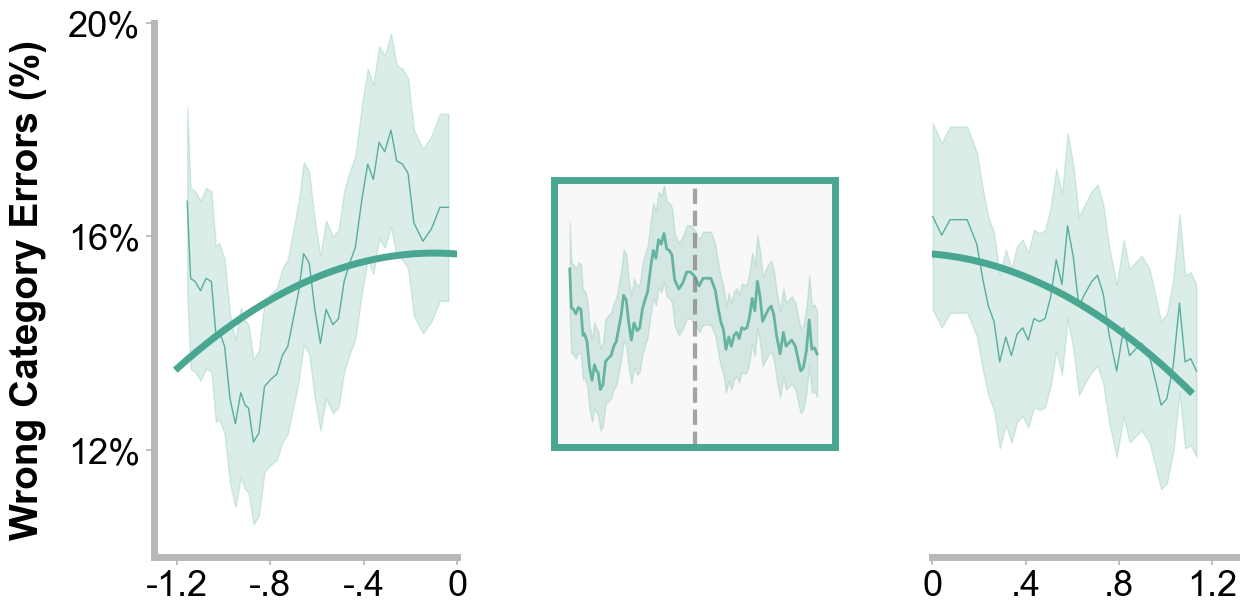

In [35]:
fig_it = create_three_panel_visualization(
    df, df_correct, df_cleaned,
    plot_configs_it,
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03
)



In [36]:
df_cleaned['Wrong Category']

0        0
1        0
2        0
3        0
4        0
        ..
17292    0
17293    1
17294    0
17295    0
17296    0
Name: Wrong Category, Length: 17297, dtype: int64

In [37]:
df_cleaned['Untested Item Error Accuracy']

0        1
1        0
2        0
3        1
4        1
        ..
17292    0
17293    0
17294    0
17295    0
17296    1
Name: Untested Item Error Accuracy, Length: 17297, dtype: int64

In [38]:
df_cleaned['last_clicked_category']

0        memory_distractor
1         correct_category
2         correct_category
3        memory_distractor
4        memory_distractor
               ...        
17292     correct_category
17293       wrong_category
17294     correct_category
17295     correct_category
17296    memory_distractor
Name: last_clicked_category, Length: 17297, dtype: object

In [39]:
df_cleaned["Error Category Accuracy"]

0        0
1        1
2        1
3        0
4        0
        ..
17292    1
17293    0
17294    1
17295    1
17296    0
Name: Error Category Accuracy, Length: 17297, dtype: int64

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator

def remove_leading_zero_formatter(x, pos):
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def create_continuous_rolling_plot(df, df_correct, df_cleaned, x_col, y_cols=None, item_col=None, 
                                 window_percent=0.1, step_percent=0.02,
                                 ax=None, 
                                 y_limits=None, x_limits=None,
                                 x_tick_step=None, y_tick_step=None, x_ticks=None,
                                 y_as_percentage=False, y_percentage_step=2,
                                 font_family='Arial',
                                 title_font_size=18, title_font_color='black', title_font_weight='bold',
                                 label_font_size=16, label_font_color='black', label_font_weight='bold',
                                 tick_font_size=14, tick_font_color='black',
                                 line_width=3, confidence_alpha=0.2,
                                 show_title=True):
    
    # Use df_cleaned for all the error measures
    df = df_cleaned.copy()
    print(f"Continuous plot using df_cleaned for error measures")
    
    # Create shorter labels for legend
    def get_short_label(y_col):
        if "Error Category Accuracy" in y_col:
            return "Within Category"
        elif "Untested Item Error Accuracy" in y_col:
            return "Untested Item"
        elif "Wrong Category" in y_col:
            return "Wrong Category"
        else:
            return y_col
    
    # Create shorter labels for legend
    def get_short_label(y_col):
        if "Error Category Accuracy" in y_col:
            return "Within Category"
        elif "Untested Item Error Accuracy" in y_col:
            return "Untested Item"
        elif "Wrong Category" in y_col:
            return "Wrong Category"
        else:
            return y_col
    
    # Default y_cols if not provided
    if y_cols is None:
        y_cols = ["Error Category Accuracy", 'Untested Item Error Accuracy', 'Wrong Category']
    
    # Create different hues of the main color for the three overlays - more distinct
    if "IT Distractor Similarity" in x_col:
        overlay_colors = ['#2d5a4f', '#49a791', '#7dc4b8']
    elif "V2 Distractor Similarity" in x_col:
        overlay_colors = ['#6b8f33', '#95c355', '#c5e677']
    else:
        overlay_colors = ['#2d5a4f', '#49a791', '#7dc4b8']
    
    # Create rolling averages for each y_col
    for i, y_col in enumerate(y_cols):
        color = overlay_colors[i % len(overlay_colors)]
        
        # This would call the combined_rolling_average_subplot function for each y_col
        # Since we don't have access to that function, we'll create a simplified version here
        df_sorted = df.sort_values(by=x_col).reset_index(drop=True)
        total_points = len(df_sorted)
        
        window_points = max(int(total_points * window_percent), 3)
        step_points = max(int(total_points * step_percent), 1)
        
        if total_points >= window_points:
            x_vals, y_vals, y_errs = [], [], []
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_sorted.iloc[j:j+window_points]
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                x_vals.append(mean_x)
                y_vals.append(mean_y)
                y_errs.append(sem_y)
            
            x_vals = np.array(x_vals)
            y_vals = np.array(y_vals)
            y_errs = np.array(y_errs)
            
            ax.plot(x_vals, y_vals, color=color, linewidth=line_width, alpha=0.9, 
                   label=get_short_label(y_col))
            ax.fill_between(x_vals, 
                           y_vals - 1.96 * y_errs,
                           y_vals + 1.96 * y_errs,
                           color=color, alpha=confidence_alpha)
    
    ax.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=3)
    
    if show_title:
        ax.set_title("Continuous", fontsize=title_font_size-2, 
                    color=title_font_color, fontweight=title_font_weight, 
                    fontfamily=font_family, pad=15)
    
    ax.set_xlabel('')
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.spines['bottom'].set_visible(False)
    
    return ax


def create_single_side_plot_with_full_fit(df, df_correct, df_cleaned, x_col, y_cols=None, item_col=None, 
                                         split_col='v2_pos_neg', split_value=0, side='left',
                                         window_percent=0.1, step_percent=0.01,
                                         ax=None, palette=None,
                                         y_limits=None, x_limits=None,
                                         x_tick_step=None, y_tick_step=None,
                                         model_order=2, trim_percentile=0,
                                         y_as_percentage=False, y_percentage_step=2,
                                         font_family='Arial',
                                         title_font_size=18, title_font_color='black', title_font_weight='bold',
                                         label_font_size=16, label_font_color='black', label_font_weight='bold',
                                         tick_font_size=14, tick_font_color='black',
                                         rolling_line_width=1, model_line_width=5,
                                         confidence_alpha=0.2, rolling_alpha=0.9,
                                         show_title=True, show_ylabel=True, show_xlabel=True):
    
    # Use df_cleaned for all the error measures
    df = df_cleaned.copy()
    print(f"Using df_cleaned for error measures")
    
    # Create shorter labels for legend
    def get_short_label(y_col):
        if "Error Category Accuracy" in y_col:
            return "Within Category"
        elif "Untested Item Error Accuracy" in y_col:
            return "Untested Item"
        elif "Wrong Category" in y_col:
            return "Wrong Category"
        else:
            return y_col
    
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
    # Create different hues of the main color for the three overlays - more distinct
    if "IT Distractor Similarity" in x_col:
        main_color = teal  # '#49a791'
        # Create three more distinct hues: darker, main, much lighter
        overlay_colors = ['#2d5a4f', '#49a791', '#7dc4b8']
    elif "V2 Distractor Similarity" in x_col:
        main_color = green  # '#95c355'
        # Create three more distinct hues: darker, main, much lighter
        overlay_colors = ['#6b8f33', '#95c355', '#c5e677']
    else:
        main_color = teal
        overlay_colors = ['#2d5a4f', '#49a791', '#7dc4b8']
    
    # Default y_cols if not provided
    if y_cols is None:
        y_cols = ["Error Category Accuracy", 'Untested Item Error Accuracy', 'Wrong Category']
    
    ax.set_facecolor('white')
    
    # Iterate through each y_col to create overlayed plots
    for i, y_col in enumerate(y_cols):
        color = overlay_colors[i % len(overlay_colors)]
        
        if item_col is not None and item_col in df.columns:
            items = df[item_col].unique()
            
            # Create rolling averages for the FULL dataset for each item
            for j, item in enumerate(items):
                df_item_full = df[df[item_col] == item].copy()
                df_item_full = df_item_full.sort_values(by=x_col).reset_index(drop=True)
                total_points_full = len(df_item_full)
                
                window_points = max(int(total_points_full * window_percent), 3)
                step_points = max(int(total_points_full * step_percent), 1)
                
                if total_points_full >= window_points:
                    print(f"Full data - {item}, {y_col}, Total points: {total_points_full}, "
                          f"Window size: {window_points}, Step size: {step_points}")
                    
                    x_vals, y_vals, y_errs = [], [], []
                    for k in range(0, total_points_full - window_points + 1, step_points):
                        window = df_item_full.iloc[k:k+window_points]
                        mean_x = window[x_col].mean()
                        mean_y = window[y_col].mean()
                        std_y = window[y_col].std()
                        sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                        x_vals.append(mean_x)
                        y_vals.append(mean_y)
                        y_errs.append(sem_y)
                    
                    x_vals = np.array(x_vals)
                    y_vals = np.array(y_vals)
                    y_errs = np.array(y_errs)
                    
                    # Filter to only show the side we want
                    if side == 'left':
                        mask = x_vals <= split_value
                    else:
                        mask = x_vals > split_value
                    
                    if np.any(mask):
                        x_side = x_vals[mask]
                        y_side = y_vals[mask]
                        y_err_side = y_errs[mask]
                        
                        ax.plot(x_side, y_side, color=color, linewidth=rolling_line_width, 
                               alpha=rolling_alpha, label=get_short_label(y_col))
                        ax.fill_between(x_side, 
                                       y_side - 1.96 * y_err_side,
                                       y_side + 1.96 * y_err_side,
                                       color=color, alpha=confidence_alpha)
        else:
            # Handle case without item_col
            df_full = df.copy().sort_values(by=x_col).reset_index(drop=True)
            total_points_full = len(df_full)
            
            window_points = max(int(total_points_full * window_percent), 3)
            step_points = max(int(total_points_full * step_percent), 1)
            
            # Rolling average for full data
            if total_points_full >= window_points:
                print(f"Full data - {y_col}, Total points: {total_points_full}, "
                      f"Window size: {window_points}, Step size: {step_points}")
                
                x_vals, y_vals, y_errs = [], [], []
                for k in range(0, total_points_full - window_points + 1, step_points):
                    window = df_full.iloc[k:k+window_points]
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    std_y = window[y_col].std()
                    sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                    x_vals.append(mean_x)
                    y_vals.append(mean_y)
                    y_errs.append(sem_y)
                
                x_vals = np.array(x_vals)
                y_vals = np.array(y_vals)
                y_errs = np.array(y_errs)
                
                # Filter to side
                if side == 'left':
                    mask = x_vals <= split_value
                else:
                    mask = x_vals > split_value
                
                if np.any(mask):
                    x_side = x_vals[mask]
                    y_side = y_vals[mask]
                    y_err_side = y_errs[mask]
                    
                    ax.plot(x_side, y_side, color=color, linewidth=rolling_line_width, 
                           alpha=rolling_alpha, label=get_short_label(y_col))
                    ax.fill_between(x_side, 
                                   y_side - 1.96 * y_err_side,
                                   y_side + 1.96 * y_err_side,
                                   color=color, alpha=confidence_alpha)
    
    # Rest of the formatting code with updated y-axis labeling...
    if show_title:
        if side == 'left':
            ax.set_title("Negative", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
        else:
            ax.set_title("Positive", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
    
    if show_xlabel:
        if x_col in ["Tested - Untested IT Distractor Similarity"]:
            ax.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif x_col in ["Tested - Untested V2 Distractor Similarity"]:
            ax.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_xlabel(x_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    else:
        ax.set_xlabel('')
    
    if show_ylabel:
        # Since we're showing multiple error measures, use a generic label
        if y_as_percentage:
            ax.set_ylabel("Error Measures (%)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
            if y_tick_step is None:
                y_tick_step = y_percentage_step / 100.0
        else:
            ax.set_ylabel("Error Measures", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
    
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    if x_limits is not None:
        if side == 'left':
            ax.set_xlim(x_limits[0], split_value)
        else:
            ax.set_xlim(split_value, x_limits[1])
    if y_limits is not None:
        ax.set_ylim(y_limits)
    
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    spine_color = '#B8B8B8'
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['left'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.grid(False)
    
    return ax

def create_three_panel_visualization(df, df_correct, df_cleaned, plot_configs, middle_width=0.35, middle_height_shift=0.0, middle_size_scale=0.7, adjustable_gap=0.01):
    
    from matplotlib.gridspec import GridSpec
    
    # Keep the exact same figure size as original
    fig = plt.figure(figsize=(18, 22))
    
    # Keep plot sizes FIXED regardless of gap size
    # Calculate what the original sizes were with gap_width = 0.01
    original_gap_width = 0.01
    original_remaining_width = 1.0 - middle_width - 2*original_gap_width
    fixed_side_width = original_remaining_width / 2 * 0.6  # This stays constant
    fixed_middle_width = middle_width  # This stays constant
    
    # Only the gap changes
    current_gap_width = adjustable_gap
    
    # Adjust outer margins to accommodate the gap change
    total_plot_width = 2 * fixed_side_width + fixed_middle_width + 2 * current_gap_width
    remaining_for_margins = 1.0 - total_plot_width
    outer_margin = remaining_for_margins / 2
    
    # Ensure margins don't go negative
    if outer_margin < 0.001:
        outer_margin = 0.001
    
    # Use the exact same GridSpec as original but only take one row
    gs = GridSpec(3, 7, figure=fig, 
                  width_ratios=[outer_margin, fixed_side_width, current_gap_width, fixed_middle_width, current_gap_width, fixed_side_width, outer_margin],  
                  height_ratios=[1, 1, 1],   
                  hspace=0.25, wspace=0.01,
                  top=0.95, bottom=0.1, left=0.05, right=0.95)
    
    # Only create axes for row 2 (the third row)
    row = 2
    ax_left = fig.add_subplot(gs[row, 1])
    ax_middle = fig.add_subplot(gs[row, 3])
    ax_right = fig.add_subplot(gs[row, 5])
    axes = [ax_left, ax_middle, ax_right]

    # Use only the third configuration (index 2) from plot_configs
    config = plot_configs[2]
    
    x_col = config['x_col']
    if "IT Distractor Similarity" in x_col:
        frame_color = '#49a791'
        # IT model orders: 3,3,2 for rows 0,1,2
        if row == 0:
            current_model_order = 3
        elif row == 1:
            current_model_order = 3
        elif row == 2:
            current_model_order = 2
        else:
            current_model_order = 2  # fallback
    elif "V2 Distractor Similarity" in x_col:
        frame_color = '#95c355'
        # V2 model orders: 3,2,1 for rows 0,1,2
        if row == 0:
            current_model_order = 3
        elif row == 1:
            current_model_order = 2
        elif row == 2:
            current_model_order = 1
        else:
            current_model_order = 2  # fallback
    else:
        frame_color = '#49a791'
        current_model_order = 2  # fallback
    
    y_limits = config.get('y_limits')
    
    # Define the three error measures to overlay
    error_measures = ["Error Category Accuracy", 'Untested Item Error Accuracy', 'Wrong Category']
    
    all_handles = []
    all_labels = []
    
    # Use the exact same function calls as in the original
    create_single_side_plot_with_full_fit(
        df, df_correct, df_cleaned,
        x_col=config['x_col'],
        y_cols=error_measures,
        item_col=config.get('item_col'),
        side='left',
        ax=axes[0],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        model_order=current_model_order,
        trim_percentile=config.get('trim_percentile', 0),
        window_percent=0.1,
        step_percent=0.01,
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),
        tick_font_size=config.get('tick_font_size', 14),
        show_title=False,
        show_ylabel=True,
        show_xlabel=False
    )
    
    # Collect legend handles and labels from the left plot
    handles, labels = axes[0].get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in all_labels:
            all_handles.append(handle)
            all_labels.append(label)
    
    axes[0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    create_continuous_rolling_plot(
        df, df_correct, df_cleaned,
        x_col=config['x_col'],
        y_cols=error_measures,
        item_col=config.get('item_col'),
        ax=axes[1],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        x_ticks=config.get('x_ticks'),
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 14),
        tick_font_size=config.get('tick_font_size', 12),
        window_percent=0.1,
        step_percent = 0.01,
        line_width=2,
        show_title=False
    )
    
    # Keep the exact same middle plot formatting as original
    axes[1].set_xlabel('')
    axes[1].tick_params(axis='x', bottom=False, labelbottom=False)
    axes[1].spines['bottom'].set_visible(False)
    
    for spine_name, spine in axes[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(5)
        spine.set_color(frame_color)
    
    axes[1].set_facecolor('#f8f8f8')
    
    pos = axes[1].get_position()
    new_width = pos.width * middle_size_scale
    new_height = pos.height * middle_size_scale
    new_x = pos.x0 + (pos.width - new_width) / 2
    new_y = pos.y0 + middle_height_shift
    
    new_pos = [new_x, new_y, new_width, new_height]
    axes[1].set_position(new_pos)
    
    create_single_side_plot_with_full_fit(
        df, df_correct, df_cleaned,
        x_col=config['x_col'],
        y_cols=error_measures,
        item_col=config.get('item_col'),
        side='right',
        ax=axes[2],
        y_limits=y_limits,
        x_limits=config.get('x_limits'),
        x_tick_step=config.get('x_tick_step'),
        y_tick_step=config.get('y_tick_step'),
        model_order=current_model_order,
        trim_percentile=config.get('trim_percentile', 0),
        window_percent=0.1,
        step_percent=0.01,
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 16),
        tick_font_size=config.get('tick_font_size', 14),
        show_title=False,
        show_ylabel=False,
        show_xlabel=False
    )
    
    axes[2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Keep the exact same axis cleanup as original
    axes[1].set_ylabel('')
    axes[1].tick_params(axis='y', labelleft=False, left=False)
    
    axes[2].set_ylabel('')
    axes[2].tick_params(axis='y', labelleft=False, left=False)
    axes[2].spines['left'].set_visible(False)
    
    axes[0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    axes[2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))

    plt.show()
    return fig

In [41]:
plot_configs_v2 = [
    {
        'df': df_correct,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None,
        'y_limits': (1500, 1620),
        'y_tick_step': 30,
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 1,
        'right_model_order': 2,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'y_limits': (0.7, 0.79),
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df_cleaned,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "Wrong Category",
        'item_col': None,
        'y_limits': (0.1, 0.3),
        'y_tick_step': 0.1,
        'y_as_percentage': True,
        'y_percentage_step': 4,
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    }
]

plot_configs_it = [
    {
        'df': df_correct,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None,
        'y_limits': (1500, 1620),
        'y_tick_step': 30,
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 2,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'y_limits': (0.7, 0.79),
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df_cleaned,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Wrong Category",
        'item_col': None,
        'y_limits': (0.1, 0.3),
        'y_tick_step': 0.1,
        'y_as_percentage': True,
        'y_percentage_step': 4,
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 1,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    }
]

Using df_cleaned for error measures
Full data - Error Category Accuracy, Total points: 17297, Window size: 1729, Step size: 172
Full data - Untested Item Error Accuracy, Total points: 17297, Window size: 1729, Step size: 172
Full data - Wrong Category, Total points: 17297, Window size: 1729, Step size: 172
Continuous plot using df_cleaned for error measures
Using df_cleaned for error measures
Full data - Error Category Accuracy, Total points: 17297, Window size: 1729, Step size: 172
Full data - Untested Item Error Accuracy, Total points: 17297, Window size: 1729, Step size: 172
Full data - Wrong Category, Total points: 17297, Window size: 1729, Step size: 172


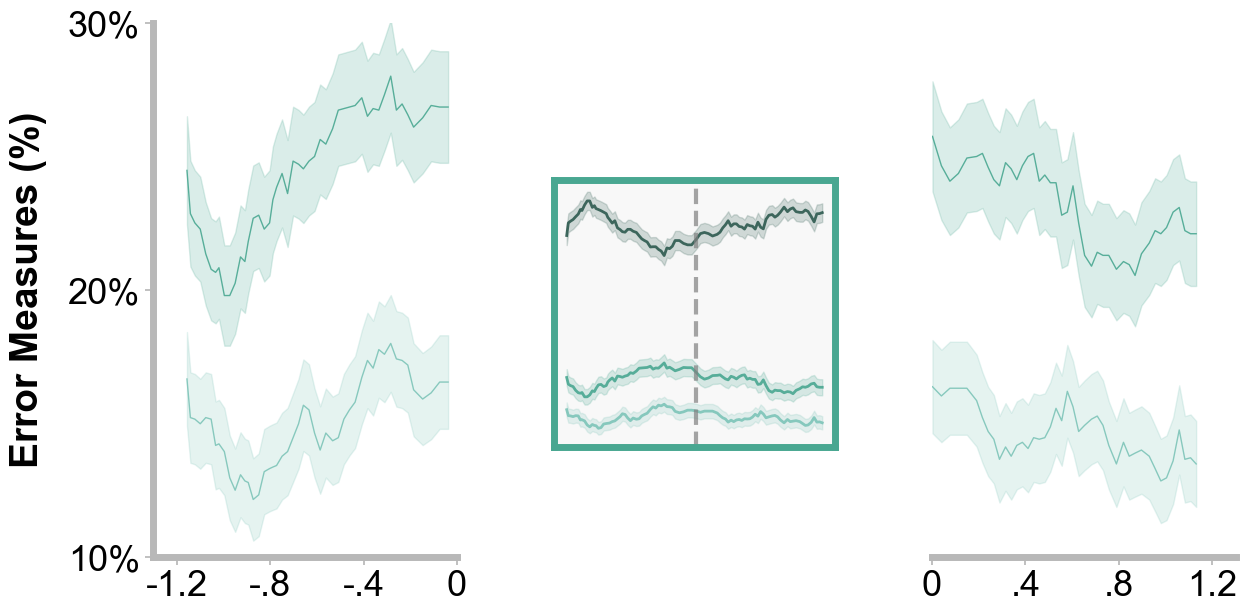

In [42]:
fig_it = create_three_panel_visualization(
    df, df_correct, df_cleaned,
    plot_configs_it,
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03
)



Using df_cleaned for error measures
Full data - Error Category Accuracy, Total points: 17297, Window size: 1729, Step size: 172
Full data - Untested Item Error Accuracy, Total points: 17297, Window size: 1729, Step size: 172
Full data - Wrong Category, Total points: 17297, Window size: 1729, Step size: 172
Continuous plot using df_cleaned for error measures
Using df_cleaned for error measures
Full data - Error Category Accuracy, Total points: 17297, Window size: 1729, Step size: 172
Full data - Untested Item Error Accuracy, Total points: 17297, Window size: 1729, Step size: 172
Full data - Wrong Category, Total points: 17297, Window size: 1729, Step size: 172


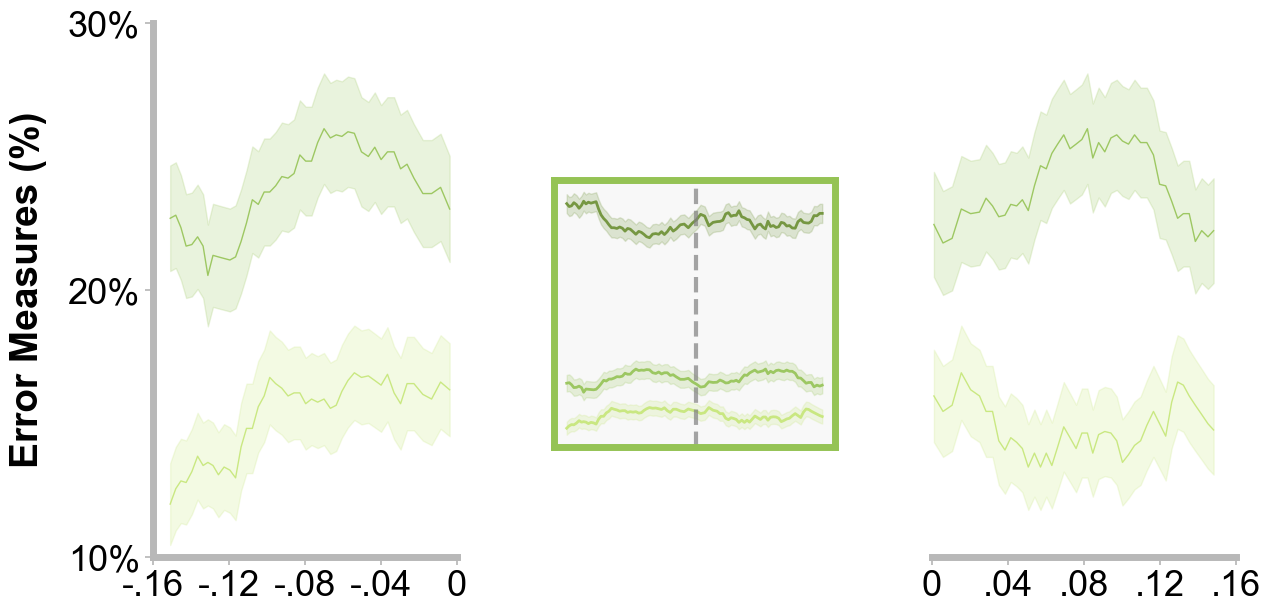

In [43]:
fig_v2 = create_three_panel_visualization(
    df, df_correct, df_cleaned,
    plot_configs_v2,
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03
)


In [44]:
# df_cleaned["Error Category Accuracy"] # darker
# df_cleaned['Untested Item Error Accuracy'] # main
# df_cleaned['Wrong Category'] # lighter